# Marelle Board import
* Getting players info dict => `MarelleBoard.players`
* 3 phases : place, move and end => `MarelleBoard.phase`
* Reset the board => `MarelleBoard.initialize_game()`
* Printing the board => `MarelleBoard.print_board()`
* Id:Action dict => `MarelleBoard.id_to_action`
* Action:Id dict => `MarelleBoard.action_to_id`
* Get the bo bard state => `MarelleBoard.get_state()`
* Play an action => `MarelleBoard.play_action(action_id, player)`
* Get legal action ids => `MarelleBoard.get_legal_action_ids(player)`
* Check if game ended (returns 0 if not ended or winning player id) : `MarelleBoard.check_if_end(player)`

In [1]:
# import importlib
# import marl_env
# import marl_agents
# import marl_models
# import marl_evaluations
# importlib.reload(marl_env)
# importlib.reload(marl_agents)
# importlib.reload(marl_models)
# importlib.reload(marl_evaluations)

from marl_env import MarelleBoard, MarelleGymEnv, MarelleGame
from marl_models import FCModel, ConvModel, ConvModel_small_output
from marl_agents import RandomAgent, BetterRandomAgent, SingleModelReinforce, ReinforceAgent, MarelleAgent, TripleModelReinforce
from marl_train import train_agent, adversarial_training
from marl_evaluations import evaluate

import os
import cProfile

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb

# Training


In [2]:
### TO DO
Graph evaluate n trajectories,
intégrer les dicos d'intermediaire lmove dans le board
finir optimize triple reinforce model.
ACTOR CRITIC !!
TRIPLE ACTION NETWORK !!
DeepL style network
#graph nb eval indicateur cvgence


## Restoring Models

In [4]:
def load_model_wandb(model_name, run_id, model):
    wandb.restore(model_name, run_path=f'clement-guillo/marl/{run_id}',root= "models/temp/")
    model.load_state_dict(torch.load(f'models/temp/{model_name}'))
    os.remove(f'models/temp/{model_name}')
    return(model)

def load_model_local(model_name, model):
    model.load_state_dict(torch.load(f'models/{model_name}'))
    return(model)

## Full game training

cpu


NameError: name 'device' is not defined

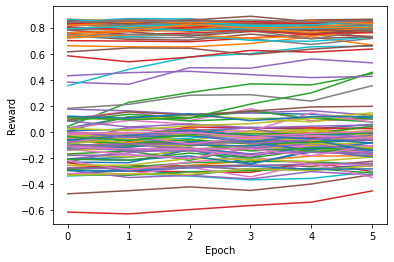

In [4]:
env = MarelleGymEnv(end_after_place_phase=False)

print(device)

# Initiate Models
einstein_conv_model_1 = ConvModel(env.N_TOTAL_ACTIONS)
einstein_conv_model_2 = ConvModel(env.N_TOTAL_ACTIONS)

# Restore models from previous trainings
einstein_conv_model_1=load_model_local("3w3zmj5x_SingleModel_Conv_500epochs_1000trajectories_20201116_55%win.pt",ConvModel(env.N_TOTAL_ACTIONS))
einstein_conv_model_2=load_model_local("3w3zmj5x_SingleModel_Conv_500epochs_1000trajectories_20201116_55%win.pt",ConvModel(env.N_TOTAL_ACTIONS))


# Agents
#einstein_fc = SingleModelReinforce(env=env, model=einstein_fc_model, lr=0.005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)
einstein_conv = SingleModelReinforce(env=env, model=einstein_conv_model, lr=0.0002, win_reward=1, defeat_reward=-1, capture_reward=0, captured_reward=-0, epsilon=0, gamma=1)

# Opponents
evaluate_agent=BetterRandomAgent(env)


# Training Conv agent
train_agent(
    env=env,
    n_epochs=10,
    n_trajectories=20,
    trained_agent=einstein_conv,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=50,
    evaluate_freq= 5
)

# Training Triple Agent

In [2]:
env = MarelleGymEnv(end_after_place_phase=False)

model_place=ConvModel_small_output(24)
model_move=ConvModel_small_output(32)
model_capture=ConvModel_small_output(24)

warrior = TripleModelReinforce(env=env, model_place=model_place,model_move=model_move,model_capture=model_capture, lr=0.001, win_reward=10000, defeat_reward=-20, capture_reward=0, captured_reward=0, epsilon=0, gamma=1)

evaluate_agent=BetterRandomAgent(env)
opponent_agent=BetterRandomAgent(env)
#opponent_agent=RandomAgent(env)


# Training Conv agent
train_agent(
    env=env,
    n_epochs=10000,
    n_trajectories=1000,
    trained_agent=warrior,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=50,
    evaluate_freq= 10000
)

/Users/clementguillo/Desktop/MARL/marl_agents.py:365: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state=torch.tensor(state, dtype=torch.float)


Episode 1/10000: rewards -20.0 +/- 0.0 - Loss : -48.61084747314453


Episode 2/10000: rewards -20.0 +/- 0.0 - Loss : -48.4697380065918


Episode 3/10000: rewards -9.98 +/- 316.7 - Loss : -24.831005096435547


Episode 4/10000: rewards -20.0 +/- 0.0 - Loss : -48.1063232421875


Episode 5/10000: rewards -20.0 +/- 0.0 - Loss : -47.96179962158203


Episode 6/10000: rewards -9.98 +/- 316.7 - Loss : -23.5528621673584


Episode 7/10000: rewards 0.04 +/- 447.66 - Loss : 0.0739697813987732


Episode 8/10000: rewards -20.0 +/- 0.0 - Loss : -47.794185638427734


Episode 9/10000: rewards -9.98 +/- 316.7 - Loss : -23.392961502075195


Episode 10/10000: rewards -20.0 +/- 0.0 - Loss : -47.87822341918945


Episode 11/10000: rewards -9.98 +/- 316.7 - Loss : -25.312089920043945


Episode 12/10000: rewards -20.0 +/- 0.0 - Loss : -47.6922721862793


Episode 13/10000: rewards -9.98 +/- 316.7 - Loss : -23.755861282348633


Episode 14/10000: rewards -20.0 +/- 0.0 - Loss : -47.52610778808594


Episode 15/10000: rewards -20.0 +/- 0.0 - Loss : -47.28204345703125


Episode 16/10000: rewards -9.98 +/- 316.7 - Loss : -25.042491912841797


Episode 17/10000: rewards 10.06 +/- 547.99 - Loss : 24.304277420043945


Episode 18/10000: rewards -9.98 +/- 316.7 - Loss : -24.179828643798828


Episode 19/10000: rewards -9.98 +/- 316.7 - Loss : -25.50374984741211


Episode 20/10000: rewards -9.98 +/- 316.7 - Loss : -22.348243713378906


Episode 21/10000: rewards 0.04 +/- 447.66 - Loss : -1.1893635988235474


Episode 22/10000: rewards 0.04 +/- 447.66 - Loss : -0.6056680679321289


Episode 23/10000: rewards -20.0 +/- 0.0 - Loss : -45.872764587402344


Episode 24/10000: rewards -9.98 +/- 316.7 - Loss : -21.476091384887695


Episode 25/10000: rewards -9.98 +/- 316.7 - Loss : -24.740236282348633


Episode 26/10000: rewards -9.98 +/- 316.7 - Loss : -22.95333480834961


Episode 27/10000: rewards -20.0 +/- 0.0 - Loss : -44.80289077758789


Episode 28/10000: rewards -9.98 +/- 316.7 - Loss : -23.200044631958008


Episode 29/10000: rewards -9.98 +/- 316.7 - Loss : -24.8339786529541


Episode 30/10000: rewards 20.08 +/- 632.45 - Loss : 42.538936614990234


Episode 31/10000: rewards 0.04 +/- 447.66 - Loss : 1.125501275062561


Episode 32/10000: rewards -9.98 +/- 316.7 - Loss : -21.073043823242188


Episode 33/10000: rewards -9.98 +/- 316.7 - Loss : -20.05474853515625


Episode 34/10000: rewards -9.98 +/- 316.7 - Loss : -24.076114654541016


Episode 35/10000: rewards 0.04 +/- 447.66 - Loss : -0.9517204761505127


Episode 36/10000: rewards 20.08 +/- 632.45 - Loss : 38.58329772949219


Episode 37/10000: rewards -9.98 +/- 316.7 - Loss : -21.89495277404785


Episode 38/10000: rewards -20.0 +/- 0.0 - Loss : -43.1967887878418


Episode 39/10000: rewards 0.04 +/- 447.66 - Loss : 1.2839329242706299


Episode 40/10000: rewards 0.04 +/- 447.66 - Loss : -2.7249343395233154


Episode 41/10000: rewards -9.98 +/- 316.7 - Loss : -23.77623176574707


Episode 42/10000: rewards -9.98 +/- 316.7 - Loss : -21.095561981201172


Episode 43/10000: rewards -9.98 +/- 316.7 - Loss : -21.25320816040039


Episode 44/10000: rewards 0.04 +/- 447.66 - Loss : 1.5498126745224


Episode 45/10000: rewards -9.98 +/- 316.7 - Loss : -22.738697052001953


Episode 46/10000: rewards 0.04 +/- 447.66 - Loss : 2.7300994396209717


Episode 47/10000: rewards 10.06 +/- 547.99 - Loss : 14.898938179016113


Episode 48/10000: rewards 20.08 +/- 632.45 - Loss : 33.93202209472656


Episode 49/10000: rewards -9.98 +/- 316.7 - Loss : -21.70382308959961


Episode 50/10000: rewards -9.98 +/- 316.7 - Loss : -18.943954467773438


Episode 51/10000: rewards -9.98 +/- 316.7 - Loss : -17.846208572387695


Episode 52/10000: rewards 0.04 +/- 447.66 - Loss : -1.7810996770858765


Episode 53/10000: rewards -9.98 +/- 316.7 - Loss : -19.729991912841797


Episode 54/10000: rewards 10.06 +/- 547.99 - Loss : 10.29734992980957


Episode 55/10000: rewards -9.98 +/- 316.7 - Loss : -21.153806686401367


Episode 56/10000: rewards -20.0 +/- 0.0 - Loss : -35.63252258300781


Episode 57/10000: rewards -9.98 +/- 316.7 - Loss : -14.383739471435547


Episode 58/10000: rewards 0.04 +/- 447.66 - Loss : -2.835822582244873


Episode 59/10000: rewards 0.04 +/- 447.66 - Loss : -3.6369235515594482


Episode 60/10000: rewards -9.98 +/- 316.7 - Loss : -16.89185905456543


Episode 61/10000: rewards 0.04 +/- 447.66 - Loss : -2.0943729877471924


Episode 62/10000: rewards 0.04 +/- 447.66 - Loss : -3.564177989959717


Episode 63/10000: rewards -20.0 +/- 0.0 - Loss : -31.51378059387207


Episode 64/10000: rewards -9.98 +/- 316.7 - Loss : -17.85041046142578


Episode 65/10000: rewards 10.06 +/- 547.99 - Loss : 19.237520217895508


Episode 66/10000: rewards 10.06 +/- 547.99 - Loss : 16.698265075683594


Episode 67/10000: rewards 10.06 +/- 547.99 - Loss : 9.380416870117188


Episode 68/10000: rewards 30.1 +/- 706.75 - Loss : 38.492034912109375


Episode 69/10000: rewards -20.0 +/- 0.0 - Loss : -28.696989059448242


Episode 70/10000: rewards 20.08 +/- 632.45 - Loss : 30.900800704956055


Episode 71/10000: rewards 40.12 +/- 773.81 - Loss : 56.870880126953125


Episode 72/10000: rewards 30.12 +/- 706.75 - Loss : 30.04360580444336


Episode 73/10000: rewards 0.04 +/- 447.66 - Loss : -3.976663827896118


Episode 74/10000: rewards 0.04 +/- 447.66 - Loss : -5.111837863922119


Episode 75/10000: rewards 40.12 +/- 773.81 - Loss : 51.60935592651367


Episode 76/10000: rewards 10.06 +/- 547.99 - Loss : 19.593669891357422


Episode 77/10000: rewards 30.1 +/- 706.75 - Loss : 32.241111755371094


Episode 78/10000: rewards 20.08 +/- 632.45 - Loss : 34.504234313964844


Episode 79/10000: rewards 40.12 +/- 773.81 - Loss : 49.41054153442383


Episode 80/10000: rewards 30.1 +/- 706.75 - Loss : 24.274648666381836


Episode 81/10000: rewards 80.2 +/- 996.98 - Loss : 98.98177337646484


Episode 82/10000: rewards 80.2 +/- 996.98 - Loss : 97.77778625488281


Episode 83/10000: rewards 70.2 +/- 946.29 - Loss : 73.25143432617188


Episode 84/10000: rewards 60.16 +/- 892.62 - Loss : 61.40339660644531


Episode 85/10000: rewards 80.2 +/- 996.98 - Loss : 91.37861633300781


Episode 86/10000: rewards 90.26 +/- 1045.11 - Loss : 97.02849578857422


Episode 87/10000: rewards 120.28 +/- 1177.25 - Loss : 109.82939910888672


Episode 88/10000: rewards 100.24 +/- 1091.03 - Loss : 104.35317993164062


Episode 89/10000: rewards 140.32 +/- 1257.26 - Loss : 137.25148010253906


Episode 90/10000: rewards 120.28 +/- 1177.25 - Loss : 117.43061065673828


Episode 91/10000: rewards 110.28 +/- 1135.0 - Loss : 92.01933288574219


Episode 92/10000: rewards 310.66 +/- 1789.94 - Loss : 277.4624328613281


Episode 93/10000: rewards 270.58 +/- 1681.42 - Loss : 257.48297119140625


Episode 94/10000: rewards 300.64 +/- 1763.52 - Loss : 281.3158874511719


Episode 95/10000: rewards 340.72 +/- 1866.63 - Loss : 282.5072021484375


Episode 96/10000: rewards 230.52 +/- 1564.37 - Loss : 191.00045776367188


Episode 97/10000: rewards 320.68 +/- 1815.92 - Loss : 270.8236389160156


Episode 98/10000: rewards 420.88 +/- 2055.05 - Loss : 348.9383544921875


Episode 99/10000: rewards 430.92 +/- 2077.18 - Loss : 332.50640869140625


Episode 100/10000: rewards 591.22 +/- 2398.09 - Loss : 461.78106689453125


Episode 101/10000: rewards 591.22 +/- 2398.09 - Loss : 462.29302978515625


Episode 102/10000: rewards 621.28 +/- 2452.42 - Loss : 462.0484619140625


Episode 103/10000: rewards 521.1 +/- 2264.69 - Loss : 382.5111083984375


Episode 104/10000: rewards 691.44 +/- 2573.38 - Loss : 496.0928955078125


Episode 105/10000: rewards 861.76 +/- 2838.61 - Loss : 605.8842163085938


Episode 106/10000: rewards 711.52 +/- 2606.55 - Loss : 484.13726806640625


Episode 107/10000: rewards 871.78 +/- 2853.13 - Loss : 578.8770751953125


Episode 108/10000: rewards 1012.06 +/- 3045.67 - Loss : 679.6874389648438


Episode 109/10000: rewards 1052.16 +/- 3097.31 - Loss : 664.5787353515625


Episode 110/10000: rewards 821.7 +/- 2779.42 - Loss : 532.882080078125


Episode 111/10000: rewards 1112.3 +/- 3172.25 - Loss : 690.95458984375


Episode 112/10000: rewards 1112.28 +/- 3172.25 - Loss : 666.5254516601562


Episode 113/10000: rewards 1012.06 +/- 3045.67 - Loss : 611.4169921875


Episode 114/10000: rewards 1232.5 +/- 3313.8 - Loss : 763.625732421875


Episode 115/10000: rewards 1102.24 +/- 3159.97 - Loss : 712.7271728515625


Episode 116/10000: rewards 1102.28 +/- 3159.96 - Loss : 640.985107421875


Episode 117/10000: rewards 1302.64 +/- 3391.68 - Loss : 771.6834716796875


Episode 118/10000: rewards 1212.48 +/- 3290.93 - Loss : 716.379150390625


Episode 119/10000: rewards 1232.5 +/- 3313.8 - Loss : 718.2925415039062


Episode 120/10000: rewards 1312.66 +/- 3402.54 - Loss : 775.3404541015625


Episode 121/10000: rewards 1372.8 +/- 3466.38 - Loss : 822.2271728515625


Episode 122/10000: rewards 1402.84 +/- 3497.48 - Loss : 792.25048828125


Episode 123/10000: rewards 1543.12 +/- 3635.81 - Loss : 842.0769653320312


Episode 124/10000: rewards 1302.68 +/- 3391.66 - Loss : 703.7942504882812


Episode 125/10000: rewards 1543.16 +/- 3635.79 - Loss : 751.0286254882812


Episode 126/10000: rewards 1422.88 +/- 3517.92 - Loss : 702.3912353515625


Episode 127/10000: rewards 1683.42 +/- 3763.83 - Loss : 824.9144287109375


Episode 128/10000: rewards 1633.3 +/- 3719.23 - Loss : 745.7914428710938


Episode 129/10000: rewards 1422.92 +/- 3517.9 - Loss : 637.6694946289062


Episode 130/10000: rewards 1703.46 +/- 3781.34 - Loss : 734.8533935546875


Episode 131/10000: rewards 1583.22 +/- 3673.38 - Loss : 623.7257080078125


Episode 132/10000: rewards 1663.38 +/- 3746.13 - Loss : 666.311279296875


Episode 133/10000: rewards 1633.34 +/- 3719.21 - Loss : 607.5374755859375


Episode 134/10000: rewards 1362.78 +/- 3455.89 - Loss : 496.1729431152344


Episode 135/10000: rewards 1673.42 +/- 3755.0 - Loss : 607.8316040039062


Episode 136/10000: rewards 1613.28 +/- 3701.04 - Loss : 528.68212890625


Episode 137/10000: rewards 1773.58 +/- 3841.19 - Loss : 604.3489990234375


Episode 138/10000: rewards 1633.36 +/- 3719.2 - Loss : 495.9989929199219


Episode 139/10000: rewards 1663.4 +/- 3746.12 - Loss : 568.1121215820312


Episode 140/10000: rewards 1943.92 +/- 3977.62 - Loss : 583.6738891601562


Episode 141/10000: rewards 1893.84 +/- 3938.74 - Loss : 493.4754333496094


Episode 142/10000: rewards 2124.32 +/- 4109.45 - Loss : 502.81573486328125


Episode 143/10000: rewards 2064.16 +/- 4066.89 - Loss : 440.5873107910156


Episode 144/10000: rewards 2034.1 +/- 4045.09 - Loss : 394.3875732421875


Episode 145/10000: rewards 2084.22 +/- 4081.22 - Loss : 385.60809326171875


Episode 146/10000: rewards 1873.82 +/- 3922.9 - Loss : 362.2455139160156


Episode 147/10000: rewards 1903.84 +/- 3946.61 - Loss : 421.16375732421875


Episode 148/10000: rewards 2154.36 +/- 4130.26 - Loss : 469.62286376953125


Episode 149/10000: rewards 2174.42 +/- 4143.94 - Loss : 477.9211120605469


Episode 150/10000: rewards 2114.3 +/- 4102.44 - Loss : 441.48101806640625


Episode 151/10000: rewards 1994.02 +/- 4015.5 - Loss : 424.7052917480469


Episode 152/10000: rewards 1964.02 +/- 3992.86 - Loss : 362.4672546386719


Episode 153/10000: rewards 2014.08 +/- 4030.36 - Loss : 396.32293701171875


Episode 154/10000: rewards 2004.1 +/- 4022.92 - Loss : 352.196044921875


Episode 155/10000: rewards 2004.12 +/- 4022.91 - Loss : 366.8327331542969


Episode 156/10000: rewards 2204.46 +/- 4164.21 - Loss : 425.6331787109375


Episode 157/10000: rewards 2014.1 +/- 4030.35 - Loss : 402.57781982421875


Episode 158/10000: rewards 2034.14 +/- 4045.07 - Loss : 397.0405578613281


Episode 159/10000: rewards 2134.34 +/- 4116.42 - Loss : 418.3611145019531


Episode 160/10000: rewards 2034.1 +/- 4045.09 - Loss : 360.78436279296875


Episode 161/10000: rewards 2114.28 +/- 4102.45 - Loss : 362.7698974609375


Episode 162/10000: rewards 2054.16 +/- 4059.65 - Loss : 317.63763427734375


Episode 163/10000: rewards 1923.9 +/- 3962.19 - Loss : 256.1070556640625


Episode 164/10000: rewards 2084.28 +/- 4081.19 - Loss : 237.0794677734375


Episode 165/10000: rewards 2074.18 +/- 4074.08 - Loss : 197.27828979492188


Episode 166/10000: rewards 2104.26 +/- 4095.41 - Loss : 152.5388641357422


Episode 167/10000: rewards 2164.4 +/- 4137.11 - Loss : 209.27029418945312


Episode 168/10000: rewards 2344.72 +/- 4254.71 - Loss : 220.37164306640625


Episode 169/10000: rewards 2034.14 +/- 4045.07 - Loss : 198.07264709472656


Episode 170/10000: rewards 2104.28 +/- 4095.4 - Loss : 219.48336791992188


Episode 171/10000: rewards 2174.4 +/- 4143.95 - Loss : 213.71807861328125


Episode 172/10000: rewards 2144.34 +/- 4123.36 - Loss : 261.3382263183594


Episode 173/10000: rewards 2154.36 +/- 4130.26 - Loss : 327.4176940917969


Episode 174/10000: rewards 2054.2 +/- 4059.63 - Loss : 272.23748779296875


Episode 175/10000: rewards 1853.76 +/- 3906.9 - Loss : 262.2022705078125


Episode 176/10000: rewards 2284.6 +/- 4216.74 - Loss : 342.3271484375


Episode 177/10000: rewards 2064.24 +/- 4066.85 - Loss : 319.0743713378906


Episode 178/10000: rewards 2054.16 +/- 4059.65 - Loss : 298.7550048828125


Episode 179/10000: rewards 2134.34 +/- 4116.42 - Loss : 319.1325988769531


Episode 180/10000: rewards 2044.12 +/- 4052.39 - Loss : 315.0418395996094


Episode 181/10000: rewards 2104.24 +/- 4095.42 - Loss : 288.5187683105469


Episode 182/10000: rewards 2254.56 +/- 4197.29 - Loss : 313.8784484863281


Episode 183/10000: rewards 2124.3 +/- 4109.46 - Loss : 285.0920104980469


Episode 184/10000: rewards 2344.72 +/- 4254.71 - Loss : 294.994384765625


Episode 185/10000: rewards 1863.8 +/- 3914.92 - Loss : 235.27447509765625


Episode 186/10000: rewards 2074.22 +/- 4074.06 - Loss : 283.3365478515625


Episode 187/10000: rewards 2204.46 +/- 4164.21 - Loss : 272.25958251953125


Episode 188/10000: rewards 2094.28 +/- 4088.31 - Loss : 209.0308380126953


Episode 189/10000: rewards 2304.66 +/- 4229.52 - Loss : 189.97056579589844


Episode 190/10000: rewards 2154.34 +/- 4130.27 - Loss : 165.14154052734375


Episode 191/10000: rewards 2314.7 +/- 4235.86 - Loss : 103.01567840576172


Episode 192/10000: rewards 2214.5 +/- 4170.89 - Loss : 159.75819396972656


Episode 193/10000: rewards 2214.46 +/- 4170.91 - Loss : 125.2448501586914


Episode 194/10000: rewards 2054.16 +/- 4059.65 - Loss : 131.9559783935547


Episode 195/10000: rewards 2214.46 +/- 4170.91 - Loss : 151.81353759765625


Episode 196/10000: rewards 1843.74 +/- 3898.84 - Loss : 144.4096221923828


Episode 197/10000: rewards 2254.54 +/- 4197.3 - Loss : 185.26693725585938


Episode 198/10000: rewards 2314.7 +/- 4235.86 - Loss : 193.478271484375


Episode 199/10000: rewards 1984.02 +/- 4007.99 - Loss : 169.87294006347656


Episode 200/10000: rewards 2144.32 +/- 4123.37 - Loss : 174.89967346191406


Episode 201/10000: rewards 2024.08 +/- 4037.75 - Loss : 172.7647705078125


Episode 202/10000: rewards 2104.24 +/- 4095.42 - Loss : 233.0968475341797


Episode 203/10000: rewards 2334.72 +/- 4248.46 - Loss : 228.3058319091797


Episode 204/10000: rewards 1994.06 +/- 4015.48 - Loss : 242.21034240722656


Episode 205/10000: rewards 1913.9 +/- 3954.4 - Loss : 219.99989318847656


Episode 206/10000: rewards 1923.88 +/- 3962.2 - Loss : 221.3538055419922


Episode 207/10000: rewards 2174.46 +/- 4143.92 - Loss : 247.7982635498047


Episode 208/10000: rewards 2294.66 +/- 4223.13 - Loss : 246.73306274414062


Episode 209/10000: rewards 2094.3 +/- 4088.3 - Loss : 216.62632751464844


Episode 210/10000: rewards 2184.42 +/- 4150.74 - Loss : 171.46603393554688


Episode 211/10000: rewards 2364.78 +/- 4267.1 - Loss : 169.22793579101562


Episode 212/10000: rewards 1923.9 +/- 3962.19 - Loss : 146.50665283203125


Episode 213/10000: rewards 2104.24 +/- 4095.42 - Loss : 137.25656127929688


Episode 214/10000: rewards 2374.82 +/- 4273.23 - Loss : 131.43344116210938


Episode 215/10000: rewards 2094.26 +/- 4088.32 - Loss : 123.35987854003906


Episode 216/10000: rewards 2134.32 +/- 4116.43 - Loss : 103.81599426269531


Episode 217/10000: rewards 2264.58 +/- 4203.81 - Loss : 158.82186889648438


Episode 218/10000: rewards 1903.9 +/- 3946.58 - Loss : 117.80081176757812


Episode 219/10000: rewards 2194.44 +/- 4157.49 - Loss : 164.25973510742188


Episode 220/10000: rewards 2144.42 +/- 4123.32 - Loss : 158.90652465820312


Episode 221/10000: rewards 2164.38 +/- 4137.12 - Loss : 160.953125


Episode 222/10000: rewards 2575.2 +/- 4389.61 - Loss : 211.29443359375


Episode 223/10000: rewards 2024.18 +/- 4037.7 - Loss : 165.1175994873047


Episode 224/10000: rewards 2164.44 +/- 4137.09 - Loss : 155.7368621826172


Episode 225/10000: rewards 2074.26 +/- 4074.03 - Loss : 168.32049560546875


Episode 226/10000: rewards 2134.32 +/- 4116.43 - Loss : 168.97499084472656


Episode 227/10000: rewards 2294.7 +/- 4223.11 - Loss : 157.66180419921875


Episode 228/10000: rewards 2214.52 +/- 4170.88 - Loss : 188.0717010498047


Episode 229/10000: rewards 2264.6 +/- 4203.8 - Loss : 149.5181427001953


Episode 230/10000: rewards 2064.18 +/- 4066.88 - Loss : 136.93878173828125


Episode 231/10000: rewards 2254.56 +/- 4197.29 - Loss : 161.18170166015625


Episode 232/10000: rewards 2084.24 +/- 4081.21 - Loss : 188.8404541015625


Episode 233/10000: rewards 2224.5 +/- 4177.55 - Loss : 198.11514282226562


Episode 234/10000: rewards 2364.86 +/- 4267.05 - Loss : 196.5888214111328


Episode 235/10000: rewards 2084.24 +/- 4081.21 - Loss : 171.4438018798828


Episode 236/10000: rewards 2114.28 +/- 4102.45 - Loss : 150.13983154296875


Episode 237/10000: rewards 2064.18 +/- 4066.88 - Loss : 135.81919860839844


Episode 238/10000: rewards 2224.52 +/- 4177.54 - Loss : 117.416259765625


Episode 239/10000: rewards 1893.94 +/- 3938.69 - Loss : 110.96073150634766


Episode 240/10000: rewards 2084.2 +/- 4081.23 - Loss : 118.38219451904297


Episode 241/10000: rewards 2214.46 +/- 4170.91 - Loss : 142.3651580810547


Episode 242/10000: rewards 2214.46 +/- 4170.91 - Loss : 143.99514770507812


Episode 243/10000: rewards 1994.04 +/- 4015.49 - Loss : 157.26229858398438


Episode 244/10000: rewards 2004.06 +/- 4022.94 - Loss : 151.2124786376953


Episode 245/10000: rewards 2044.12 +/- 4052.39 - Loss : 148.51901245117188


Episode 246/10000: rewards 2034.12 +/- 4045.08 - Loss : 152.06028747558594


Episode 247/10000: rewards 2314.68 +/- 4235.87 - Loss : 179.0821990966797


Episode 248/10000: rewards 2194.46 +/- 4157.48 - Loss : 155.16000366210938


Episode 249/10000: rewards 2154.36 +/- 4130.26 - Loss : 130.4929962158203


Episode 250/10000: rewards 2254.58 +/- 4197.28 - Loss : 175.60284423828125


Episode 251/10000: rewards 1984.0 +/- 4008.0 - Loss : 165.98179626464844


Episode 252/10000: rewards 2044.16 +/- 4052.37 - Loss : 127.29042053222656


Episode 253/10000: rewards 2254.6 +/- 4197.27 - Loss : 141.52391052246094


Episode 254/10000: rewards 2044.14 +/- 4052.38 - Loss : 120.07099151611328


Episode 255/10000: rewards 2044.14 +/- 4052.38 - Loss : 97.84114837646484


Episode 256/10000: rewards 2034.1 +/- 4045.09 - Loss : 104.20355224609375


Episode 257/10000: rewards 2164.4 +/- 4137.11 - Loss : 122.96839141845703


Episode 258/10000: rewards 2034.14 +/- 4045.07 - Loss : 87.42267608642578


Episode 259/10000: rewards 2144.36 +/- 4123.35 - Loss : 108.53421783447266


Episode 260/10000: rewards 1943.94 +/- 3977.61 - Loss : 94.2038345336914


Episode 261/10000: rewards 2054.16 +/- 4059.65 - Loss : 121.43685913085938


Episode 262/10000: rewards 1933.96 +/- 3969.9 - Loss : 130.3103790283203


Episode 263/10000: rewards 2144.34 +/- 4123.36 - Loss : 140.2194366455078


Episode 264/10000: rewards 2144.36 +/- 4123.35 - Loss : 142.0748748779297


Episode 265/10000: rewards 2254.56 +/- 4197.29 - Loss : 130.34400939941406


Episode 266/10000: rewards 2234.52 +/- 4184.16 - Loss : 157.54644775390625


Episode 267/10000: rewards 2104.3 +/- 4095.39 - Loss : 131.96331787109375


Episode 268/10000: rewards 2154.36 +/- 4130.26 - Loss : 133.65322875976562


Episode 269/10000: rewards 2164.36 +/- 4137.13 - Loss : 109.39749145507812


Episode 270/10000: rewards 1823.76 +/- 3882.55 - Loss : 70.56182098388672


Episode 271/10000: rewards 2154.36 +/- 4130.26 - Loss : 101.36595153808594


Episode 272/10000: rewards 2214.48 +/- 4170.9 - Loss : 92.79369354248047


Episode 273/10000: rewards 2164.42 +/- 4137.1 - Loss : 74.89326477050781


Episode 274/10000: rewards 2014.12 +/- 4030.34 - Loss : 53.59419250488281


Episode 275/10000: rewards 1974.02 +/- 4000.45 - Loss : 64.84575653076172


Episode 276/10000: rewards 1923.9 +/- 3962.19 - Loss : 80.65910339355469


Episode 277/10000: rewards 1903.84 +/- 3946.61 - Loss : 62.719547271728516


Episode 278/10000: rewards 2184.4 +/- 4150.75 - Loss : 91.78500366210938


Episode 279/10000: rewards 2224.5 +/- 4177.55 - Loss : 75.02073669433594


Episode 280/10000: rewards 2174.42 +/- 4143.94 - Loss : 116.34971618652344


Episode 281/10000: rewards 2324.72 +/- 4242.17 - Loss : 133.2206268310547


Episode 282/10000: rewards 2124.3 +/- 4109.46 - Loss : 134.30149841308594


Episode 283/10000: rewards 2204.44 +/- 4164.22 - Loss : 142.62274169921875


Episode 284/10000: rewards 1974.0 +/- 4000.46 - Loss : 139.90110778808594


Episode 285/10000: rewards 2214.46 +/- 4170.91 - Loss : 160.07962036132812


Episode 286/10000: rewards 2074.22 +/- 4074.06 - Loss : 137.04776000976562


Episode 287/10000: rewards 2094.26 +/- 4088.32 - Loss : 134.757568359375


Episode 288/10000: rewards 2174.42 +/- 4143.94 - Loss : 135.50926208496094


Episode 289/10000: rewards 1893.88 +/- 3938.72 - Loss : 83.9979476928711


Episode 290/10000: rewards 2464.98 +/- 4327.14 - Loss : 105.26344299316406


Episode 291/10000: rewards 1763.58 +/- 3832.77 - Loss : 46.57052993774414


Episode 292/10000: rewards 2214.48 +/- 4170.9 - Loss : 85.16044616699219


Episode 293/10000: rewards 2064.18 +/- 4066.88 - Loss : 61.64716339111328


Episode 294/10000: rewards 2134.3 +/- 4116.44 - Loss : 58.58694076538086


Episode 295/10000: rewards 2134.32 +/- 4116.43 - Loss : 67.94591522216797


Episode 296/10000: rewards 1813.68 +/- 3874.39 - Loss : 68.10720825195312


Episode 297/10000: rewards 2164.36 +/- 4137.13 - Loss : 82.86868286132812


Episode 298/10000: rewards 1963.98 +/- 3992.88 - Loss : 69.3106460571289


Episode 299/10000: rewards 2144.34 +/- 4123.36 - Loss : 79.31847381591797


Episode 300/10000: rewards 2154.36 +/- 4130.26 - Loss : 111.98753356933594


Episode 301/10000: rewards 2074.22 +/- 4074.06 - Loss : 98.58494567871094


Episode 302/10000: rewards 2074.22 +/- 4074.06 - Loss : 65.72540283203125


Episode 303/10000: rewards 2294.62 +/- 4223.15 - Loss : 54.11086654663086


Episode 304/10000: rewards 1933.9 +/- 3969.93 - Loss : 66.23757934570312


Episode 305/10000: rewards 2264.62 +/- 4203.78 - Loss : 75.59268951416016


Episode 306/10000: rewards 2184.4 +/- 4150.75 - Loss : 43.602787017822266


Episode 307/10000: rewards 2154.38 +/- 4130.25 - Loss : 56.707679748535156


Episode 308/10000: rewards 2024.12 +/- 4037.73 - Loss : 38.65544128417969


Episode 309/10000: rewards 2114.28 +/- 4102.45 - Loss : 57.307125091552734


Episode 310/10000: rewards 1943.94 +/- 3977.61 - Loss : 87.7178726196289


Episode 311/10000: rewards 2264.6 +/- 4203.8 - Loss : 69.09994506835938


Episode 312/10000: rewards 2044.12 +/- 4052.39 - Loss : 55.20278549194336


Episode 313/10000: rewards 2024.12 +/- 4037.73 - Loss : 52.075279235839844


Episode 314/10000: rewards 2344.76 +/- 4254.69 - Loss : 58.53315734863281


Episode 315/10000: rewards 1903.86 +/- 3946.6 - Loss : 60.46804428100586


Episode 316/10000: rewards 2104.26 +/- 4095.41 - Loss : 58.64530944824219


Episode 317/10000: rewards 2124.34 +/- 4109.44 - Loss : 69.51969909667969


Episode 318/10000: rewards 2264.56 +/- 4203.82 - Loss : 83.67437744140625


Episode 319/10000: rewards 1953.96 +/- 3985.27 - Loss : 60.045894622802734


Episode 320/10000: rewards 2224.5 +/- 4177.55 - Loss : 58.34782791137695


Episode 321/10000: rewards 2204.48 +/- 4164.2 - Loss : 83.92192077636719


Episode 322/10000: rewards 2134.32 +/- 4116.43 - Loss : 63.654109954833984


Episode 323/10000: rewards 2244.56 +/- 4190.73 - Loss : 113.15174102783203


Episode 324/10000: rewards 2064.18 +/- 4066.88 - Loss : 76.50958251953125


Episode 325/10000: rewards 2204.48 +/- 4164.2 - Loss : 83.59523010253906


Episode 326/10000: rewards 2044.2 +/- 4052.35 - Loss : 85.63406372070312


Episode 327/10000: rewards 2014.08 +/- 4030.36 - Loss : 89.17837524414062


Episode 328/10000: rewards 2094.22 +/- 4088.34 - Loss : 92.4627456665039


Episode 329/10000: rewards 2314.7 +/- 4235.86 - Loss : 103.00570678710938


Episode 330/10000: rewards 2024.08 +/- 4037.75 - Loss : 91.3177719116211


Episode 331/10000: rewards 2114.32 +/- 4102.43 - Loss : 109.44654083251953


Episode 332/10000: rewards 2224.48 +/- 4177.56 - Loss : 92.13463592529297


Episode 333/10000: rewards 2034.14 +/- 4045.07 - Loss : 91.0969009399414


Episode 334/10000: rewards 2154.38 +/- 4130.25 - Loss : 55.57080841064453


Episode 335/10000: rewards 2194.42 +/- 4157.5 - Loss : 83.31316375732422


Episode 336/10000: rewards 2004.1 +/- 4022.92 - Loss : 61.87428283691406


Episode 337/10000: rewards 2424.9 +/- 4303.51 - Loss : 82.17208862304688


Episode 338/10000: rewards 2024.12 +/- 4037.73 - Loss : 68.88790893554688


Episode 339/10000: rewards 2024.1 +/- 4037.74 - Loss : 84.68440246582031


Episode 340/10000: rewards 2154.34 +/- 4130.27 - Loss : 94.10014343261719


Episode 341/10000: rewards 2164.38 +/- 4137.12 - Loss : 85.17668151855469


Episode 342/10000: rewards 2184.42 +/- 4150.74 - Loss : 101.01995849609375


Episode 343/10000: rewards 1943.94 +/- 3977.61 - Loss : 111.85472106933594


Episode 344/10000: rewards 2154.34 +/- 4130.27 - Loss : 113.2034912109375


Episode 345/10000: rewards 2164.4 +/- 4137.11 - Loss : 131.1678924560547


Episode 346/10000: rewards 2354.76 +/- 4260.92 - Loss : 131.52378845214844


Episode 347/10000: rewards 2164.42 +/- 4137.1 - Loss : 142.63449096679688


Episode 348/10000: rewards 2174.46 +/- 4143.92 - Loss : 159.2152557373047


Episode 349/10000: rewards 2014.08 +/- 4030.36 - Loss : 124.88037872314453


Episode 350/10000: rewards 2144.32 +/- 4123.37 - Loss : 127.58915710449219


Episode 351/10000: rewards 2184.4 +/- 4150.75 - Loss : 120.4010238647461


Episode 352/10000: rewards 2054.16 +/- 4059.65 - Loss : 110.57084655761719


Episode 353/10000: rewards 2164.48 +/- 4137.07 - Loss : 89.89974975585938


Episode 354/10000: rewards 2044.12 +/- 4052.39 - Loss : 87.1813735961914


Episode 355/10000: rewards 2134.32 +/- 4116.43 - Loss : 72.85281372070312


Episode 356/10000: rewards 2274.6 +/- 4210.29 - Loss : 65.22256469726562


Episode 357/10000: rewards 1913.88 +/- 3954.41 - Loss : 85.24046325683594


Episode 358/10000: rewards 2264.58 +/- 4203.81 - Loss : 95.79963684082031


Episode 359/10000: rewards 2124.3 +/- 4109.46 - Loss : 92.75654602050781


Episode 360/10000: rewards 2274.62 +/- 4210.27 - Loss : 119.80143737792969


Episode 361/10000: rewards 2044.14 +/- 4052.38 - Loss : 101.33517456054688


Episode 362/10000: rewards 2244.52 +/- 4190.76 - Loss : 109.86116027832031


Episode 363/10000: rewards 2444.94 +/- 4315.39 - Loss : 103.8864517211914


Episode 364/10000: rewards 2044.2 +/- 4052.35 - Loss : 86.51776123046875


Episode 365/10000: rewards 2134.3 +/- 4116.44 - Loss : 87.85787200927734


Episode 366/10000: rewards 2124.3 +/- 4109.46 - Loss : 75.87845611572266


Episode 367/10000: rewards 1783.62 +/- 3849.55 - Loss : 59.47133255004883


Episode 368/10000: rewards 2144.36 +/- 4123.35 - Loss : 69.06953430175781


Episode 369/10000: rewards 1933.94 +/- 3969.91 - Loss : 106.65463256835938


Episode 370/10000: rewards 2294.64 +/- 4223.14 - Loss : 62.35489273071289


Episode 371/10000: rewards 2054.18 +/- 4059.64 - Loss : 84.99472045898438


Episode 372/10000: rewards 2074.2 +/- 4074.07 - Loss : 64.5627212524414


Episode 373/10000: rewards 2304.66 +/- 4229.52 - Loss : 77.77914428710938


Episode 374/10000: rewards 2074.2 +/- 4074.07 - Loss : 58.17219924926758


Episode 375/10000: rewards 2094.22 +/- 4088.34 - Loss : 65.94420623779297


Episode 376/10000: rewards 1923.96 +/- 3962.16 - Loss : 55.248844146728516


Episode 377/10000: rewards 2024.08 +/- 4037.75 - Loss : 95.02369689941406


Episode 378/10000: rewards 2214.58 +/- 4170.84 - Loss : 69.5443344116211


Episode 379/10000: rewards 2184.4 +/- 4150.75 - Loss : 79.54621887207031


Episode 380/10000: rewards 2194.46 +/- 4157.48 - Loss : 78.118408203125


Episode 381/10000: rewards 2054.16 +/- 4059.65 - Loss : 58.19506072998047


Episode 382/10000: rewards 2284.6 +/- 4216.74 - Loss : 42.61724090576172


Episode 383/10000: rewards 2124.32 +/- 4109.45 - Loss : 59.36101531982422


Episode 384/10000: rewards 2094.22 +/- 4088.34 - Loss : 37.123477935791016


Episode 385/10000: rewards 2234.52 +/- 4184.16 - Loss : 44.599239349365234


Episode 386/10000: rewards 2014.08 +/- 4030.36 - Loss : 31.118057250976562


Episode 387/10000: rewards 2024.1 +/- 4037.74 - Loss : 35.5738525390625


Episode 388/10000: rewards 2084.28 +/- 4081.19 - Loss : 19.695051193237305


Episode 389/10000: rewards 1953.96 +/- 3985.27 - Loss : 42.12868881225586


Episode 390/10000: rewards 2174.42 +/- 4143.94 - Loss : 27.241384506225586


Episode 391/10000: rewards 2204.46 +/- 4164.21 - Loss : 21.7963924407959


Episode 392/10000: rewards 2374.78 +/- 4273.26 - Loss : 29.914936065673828


Episode 393/10000: rewards 2254.6 +/- 4197.27 - Loss : 25.221933364868164


Episode 394/10000: rewards 2204.5 +/- 4164.19 - Loss : 34.21071243286133


Episode 395/10000: rewards 1974.0 +/- 4000.46 - Loss : 22.737585067749023


Episode 396/10000: rewards 2254.54 +/- 4197.3 - Loss : 29.243621826171875


Episode 397/10000: rewards 1933.96 +/- 3969.9 - Loss : 5.8951873779296875


Episode 398/10000: rewards 2094.22 +/- 4088.34 - Loss : 42.276649475097656


Episode 399/10000: rewards 2354.74 +/- 4260.93 - Loss : 37.78146743774414


Episode 400/10000: rewards 2184.4 +/- 4150.75 - Loss : 54.414588928222656


Episode 401/10000: rewards 2184.48 +/- 4150.71 - Loss : 44.1362190246582


Episode 402/10000: rewards 2094.22 +/- 4088.34 - Loss : 43.0019645690918


Episode 403/10000: rewards 2234.52 +/- 4184.16 - Loss : 80.07732391357422


Episode 404/10000: rewards 2154.38 +/- 4130.25 - Loss : 68.85530090332031


Episode 405/10000: rewards 2024.1 +/- 4037.74 - Loss : 75.7637939453125


Episode 406/10000: rewards 2254.58 +/- 4197.28 - Loss : 112.03611755371094


Episode 407/10000: rewards 2084.22 +/- 4081.22 - Loss : 108.88705444335938


Episode 408/10000: rewards 2114.28 +/- 4102.45 - Loss : 114.75086212158203


Episode 409/10000: rewards 1984.04 +/- 4007.98 - Loss : 103.89546966552734


Episode 410/10000: rewards 2054.16 +/- 4059.65 - Loss : 90.09876251220703


Episode 411/10000: rewards 1893.86 +/- 3938.73 - Loss : 76.9976806640625


Episode 412/10000: rewards 2194.46 +/- 4157.48 - Loss : 62.38572311401367


Episode 413/10000: rewards 2094.26 +/- 4088.32 - Loss : 74.8346939086914


Episode 414/10000: rewards 2164.42 +/- 4137.1 - Loss : 64.7907943725586


Episode 415/10000: rewards 1803.68 +/- 3866.14 - Loss : 61.889896392822266


Episode 416/10000: rewards 1903.84 +/- 3946.61 - Loss : 51.32500457763672


Episode 417/10000: rewards 2124.3 +/- 4109.46 - Loss : 65.65754699707031


Episode 418/10000: rewards 2094.26 +/- 4088.32 - Loss : 47.004913330078125


Episode 419/10000: rewards 1984.0 +/- 4008.0 - Loss : 58.39627456665039


Episode 420/10000: rewards 2044.12 +/- 4052.39 - Loss : 70.98405456542969


Episode 421/10000: rewards 2134.36 +/- 4116.41 - Loss : 54.74833297729492


Episode 422/10000: rewards 2274.58 +/- 4210.3 - Loss : 66.46271514892578


Episode 423/10000: rewards 1863.78 +/- 3914.93 - Loss : 68.02693939208984


Episode 424/10000: rewards 2144.36 +/- 4123.35 - Loss : 59.20832061767578


Episode 425/10000: rewards 2134.32 +/- 4116.43 - Loss : 63.72323226928711


Episode 426/10000: rewards 2244.56 +/- 4190.73 - Loss : 53.448143005371094


Episode 427/10000: rewards 1973.98 +/- 4000.47 - Loss : 61.163856506347656


Episode 428/10000: rewards 2114.3 +/- 4102.44 - Loss : 25.63166618347168


Episode 429/10000: rewards 1974.0 +/- 4000.46 - Loss : 47.98591232299805


Episode 430/10000: rewards 2024.12 +/- 4037.73 - Loss : 26.16954803466797


Episode 431/10000: rewards 2234.52 +/- 4184.16 - Loss : 32.01686096191406


Episode 432/10000: rewards 2044.12 +/- 4052.39 - Loss : 33.729461669921875


Episode 433/10000: rewards 2004.08 +/- 4022.93 - Loss : 23.993257522583008


Episode 434/10000: rewards 2044.14 +/- 4052.38 - Loss : 12.452225685119629


Episode 435/10000: rewards 1903.86 +/- 3946.6 - Loss : 31.094453811645508


Episode 436/10000: rewards 2254.56 +/- 4197.29 - Loss : 13.46609878540039


Episode 437/10000: rewards 1964.0 +/- 3992.87 - Loss : 16.41111946105957


Episode 438/10000: rewards 1873.78 +/- 3922.92 - Loss : 16.141429901123047


Episode 439/10000: rewards 2174.4 +/- 4143.95 - Loss : 16.80226707458496


Episode 440/10000: rewards 1994.04 +/- 4015.49 - Loss : 8.955124855041504


Episode 441/10000: rewards 2054.16 +/- 4059.65 - Loss : 29.57098388671875


Episode 442/10000: rewards 2324.72 +/- 4242.17 - Loss : 53.89098358154297


Episode 443/10000: rewards 2124.28 +/- 4109.47 - Loss : 22.649404525756836


Episode 444/10000: rewards 2004.08 +/- 4022.93 - Loss : 18.570083618164062


Episode 445/10000: rewards 2014.1 +/- 4030.35 - Loss : 2.2403533458709717


Episode 446/10000: rewards 2334.7 +/- 4248.47 - Loss : 10.674542427062988


Episode 447/10000: rewards 2194.42 +/- 4157.5 - Loss : 3.40496826171875


Episode 448/10000: rewards 2204.46 +/- 4164.21 - Loss : 7.374794006347656


Episode 449/10000: rewards 2244.52 +/- 4190.76 - Loss : 31.30331039428711


Episode 450/10000: rewards 2104.24 +/- 4095.42 - Loss : 5.949390888214111


Episode 451/10000: rewards 2164.4 +/- 4137.11 - Loss : 24.757966995239258


Episode 452/10000: rewards 2334.72 +/- 4248.46 - Loss : 16.162214279174805


Episode 453/10000: rewards 2094.22 +/- 4088.34 - Loss : 17.098854064941406


Episode 454/10000: rewards 2194.44 +/- 4157.49 - Loss : 33.750701904296875


Episode 455/10000: rewards 1963.96 +/- 3992.89 - Loss : 18.8273983001709


Episode 456/10000: rewards 2184.44 +/- 4150.73 - Loss : 31.028602600097656


Episode 457/10000: rewards 2104.24 +/- 4095.42 - Loss : 22.45842742919922


Episode 458/10000: rewards 2114.26 +/- 4102.47 - Loss : 25.79854965209961


Episode 459/10000: rewards 2214.5 +/- 4170.89 - Loss : 13.613365173339844


Episode 460/10000: rewards 2034.1 +/- 4045.09 - Loss : 29.957496643066406


Episode 461/10000: rewards 2194.44 +/- 4157.49 - Loss : 10.142501831054688


Episode 462/10000: rewards 2284.62 +/- 4216.73 - Loss : 23.4661808013916


Episode 463/10000: rewards 2244.54 +/- 4190.75 - Loss : 12.615232467651367


Episode 464/10000: rewards 1973.98 +/- 4000.47 - Loss : 37.48398208618164


Episode 465/10000: rewards 2164.36 +/- 4137.13 - Loss : 25.55568504333496


Episode 466/10000: rewards 2464.96 +/- 4327.16 - Loss : 25.609241485595703


Episode 467/10000: rewards 2184.4 +/- 4150.75 - Loss : 13.685657501220703


Episode 468/10000: rewards 2304.66 +/- 4229.52 - Loss : 30.7998046875


Episode 469/10000: rewards 2374.84 +/- 4273.22 - Loss : 13.79457950592041


Episode 470/10000: rewards 2074.18 +/- 4074.08 - Loss : 15.220358848571777


Episode 471/10000: rewards 2224.48 +/- 4177.56 - Loss : 29.871109008789062


Episode 472/10000: rewards 2014.06 +/- 4030.37 - Loss : 19.619842529296875


Episode 473/10000: rewards 1973.98 +/- 4000.47 - Loss : 24.759145736694336


Episode 474/10000: rewards 2134.3 +/- 4116.44 - Loss : 39.60051345825195


Episode 475/10000: rewards 2344.72 +/- 4254.71 - Loss : 44.729984283447266


Episode 476/10000: rewards 2264.56 +/- 4203.82 - Loss : 27.49388885498047


Episode 477/10000: rewards 2064.18 +/- 4066.88 - Loss : 3.4835312366485596


Episode 478/10000: rewards 1953.96 +/- 3985.27 - Loss : 17.510318756103516


Episode 479/10000: rewards 2294.62 +/- 4223.15 - Loss : 25.299528121948242


Episode 480/10000: rewards 2224.48 +/- 4177.56 - Loss : 31.06490707397461


Episode 481/10000: rewards 2094.24 +/- 4088.33 - Loss : 17.27150535583496


Episode 482/10000: rewards 2054.14 +/- 4059.66 - Loss : 20.316932678222656


Episode 483/10000: rewards 2094.22 +/- 4088.34 - Loss : 19.936731338500977


Episode 484/10000: rewards 2224.48 +/- 4177.56 - Loss : 19.496501922607422


Episode 485/10000: rewards 2434.9 +/- 4309.47 - Loss : 31.082040786743164


Episode 486/10000: rewards 1973.98 +/- 4000.47 - Loss : 25.759443283081055


Episode 487/10000: rewards 2044.12 +/- 4052.39 - Loss : 26.256155014038086


Episode 488/10000: rewards 2144.36 +/- 4123.35 - Loss : 36.7591667175293


Episode 489/10000: rewards 2254.58 +/- 4197.28 - Loss : 21.665180206298828


Episode 490/10000: rewards 2214.46 +/- 4170.91 - Loss : 33.37179183959961


Episode 491/10000: rewards 2174.42 +/- 4143.94 - Loss : 35.7838249206543


Episode 492/10000: rewards 1873.84 +/- 3922.89 - Loss : 28.038803100585938


Episode 493/10000: rewards 2184.44 +/- 4150.73 - Loss : 30.635822296142578


Episode 494/10000: rewards 2024.12 +/- 4037.73 - Loss : 30.955585479736328


Episode 495/10000: rewards 2044.16 +/- 4052.37 - Loss : 34.81631088256836


Episode 496/10000: rewards 2354.74 +/- 4260.93 - Loss : 53.00032424926758


Episode 497/10000: rewards 2154.34 +/- 4130.27 - Loss : 56.29487609863281


Episode 498/10000: rewards 2084.24 +/- 4081.21 - Loss : 50.16120910644531


Episode 499/10000: rewards 1963.96 +/- 3992.89 - Loss : 41.151390075683594


Episode 500/10000: rewards 2024.08 +/- 4037.75 - Loss : 35.835243225097656


Episode 501/10000: rewards 2034.1 +/- 4045.09 - Loss : 49.89384841918945


Episode 502/10000: rewards 2084.2 +/- 4081.23 - Loss : 44.69523620605469


Episode 503/10000: rewards 2074.24 +/- 4074.05 - Loss : 55.777442932128906


Episode 504/10000: rewards 2144.32 +/- 4123.37 - Loss : 38.394927978515625


Episode 505/10000: rewards 2224.52 +/- 4177.54 - Loss : 59.02928161621094


Episode 506/10000: rewards 1863.78 +/- 3914.93 - Loss : 50.084049224853516


Episode 507/10000: rewards 2084.2 +/- 4081.23 - Loss : 35.68437957763672


Episode 508/10000: rewards 2094.22 +/- 4088.34 - Loss : 53.5478401184082


Episode 509/10000: rewards 2094.24 +/- 4088.33 - Loss : 48.53997039794922


Episode 510/10000: rewards 2084.2 +/- 4081.23 - Loss : 39.750240325927734


Episode 511/10000: rewards 2414.86 +/- 4297.53 - Loss : 18.5390625


Episode 512/10000: rewards 2064.2 +/- 4066.87 - Loss : 35.6135139465332


Episode 513/10000: rewards 2064.16 +/- 4066.89 - Loss : 41.60227966308594


Episode 514/10000: rewards 2124.3 +/- 4109.46 - Loss : 26.5893497467041


Episode 515/10000: rewards 2184.4 +/- 4150.75 - Loss : 49.007083892822266


Episode 516/10000: rewards 2034.1 +/- 4045.09 - Loss : 22.986486434936523


Episode 517/10000: rewards 2184.4 +/- 4150.75 - Loss : 61.58490753173828


Episode 518/10000: rewards 2124.3 +/- 4109.46 - Loss : 65.38001251220703


Episode 519/10000: rewards 2144.32 +/- 4123.37 - Loss : 67.80423736572266


Episode 520/10000: rewards 2234.52 +/- 4184.16 - Loss : 90.3836441040039


Episode 521/10000: rewards 2004.06 +/- 4022.94 - Loss : 97.21882629394531


Episode 522/10000: rewards 1933.94 +/- 3969.91 - Loss : 142.78909301757812


Episode 523/10000: rewards 2074.18 +/- 4074.08 - Loss : 165.94924926757812


Episode 524/10000: rewards 2254.56 +/- 4197.29 - Loss : 177.38284301757812


Episode 525/10000: rewards 1853.76 +/- 3906.9 - Loss : 166.3331756591797


Episode 526/10000: rewards 1923.9 +/- 3962.19 - Loss : 129.83619689941406


Episode 527/10000: rewards 2134.3 +/- 4116.44 - Loss : 140.027099609375


Episode 528/10000: rewards 2104.26 +/- 4095.41 - Loss : 133.60629272460938


Episode 529/10000: rewards 2044.12 +/- 4052.39 - Loss : 142.0924835205078


Episode 530/10000: rewards 2104.26 +/- 4095.41 - Loss : 177.45799255371094


Episode 531/10000: rewards 2054.18 +/- 4059.64 - Loss : 194.8212432861328


Episode 532/10000: rewards 1933.9 +/- 3969.93 - Loss : 192.77554321289062


Episode 533/10000: rewards 2034.12 +/- 4045.08 - Loss : 181.7119903564453


Episode 534/10000: rewards 1943.94 +/- 3977.61 - Loss : 155.1480712890625


Episode 535/10000: rewards 2234.5 +/- 4184.17 - Loss : 152.01075744628906


Episode 536/10000: rewards 1984.02 +/- 4007.99 - Loss : 119.4085464477539


Episode 537/10000: rewards 2004.1 +/- 4022.92 - Loss : 119.57366180419922


Episode 538/10000: rewards 2084.22 +/- 4081.22 - Loss : 90.28681945800781


Episode 539/10000: rewards 1963.96 +/- 3992.89 - Loss : 77.01972961425781


Episode 540/10000: rewards 2034.12 +/- 4045.08 - Loss : 61.1536979675293


Episode 541/10000: rewards 2124.3 +/- 4109.46 - Loss : 75.74756622314453


Episode 542/10000: rewards 2424.92 +/- 4303.49 - Loss : 70.05902862548828


Episode 543/10000: rewards 1823.72 +/- 3882.57 - Loss : 58.11738967895508


Episode 544/10000: rewards 2164.36 +/- 4137.13 - Loss : 55.71186447143555


Episode 545/10000: rewards 2094.24 +/- 4088.33 - Loss : 46.984527587890625


Episode 546/10000: rewards 2104.28 +/- 4095.4 - Loss : 58.18065643310547


Episode 547/10000: rewards 2034.1 +/- 4045.09 - Loss : 62.50163269042969


Episode 548/10000: rewards 1954.0 +/- 3985.25 - Loss : 54.30142593383789


Episode 549/10000: rewards 2194.42 +/- 4157.5 - Loss : 51.209476470947266


Episode 550/10000: rewards 2164.38 +/- 4137.12 - Loss : 45.47810363769531


Episode 551/10000: rewards 2294.62 +/- 4223.15 - Loss : 17.267492294311523


Episode 552/10000: rewards 2184.4 +/- 4150.75 - Loss : 28.94281578063965


Episode 553/10000: rewards 2274.64 +/- 4210.26 - Loss : 10.00001335144043


Episode 554/10000: rewards 2264.56 +/- 4203.82 - Loss : 23.033069610595703


Episode 555/10000: rewards 2084.22 +/- 4081.22 - Loss : 21.974693298339844


Episode 556/10000: rewards 2264.58 +/- 4203.81 - Loss : 18.096033096313477


Episode 557/10000: rewards 1943.94 +/- 3977.61 - Loss : 13.090392112731934


Episode 558/10000: rewards 2104.26 +/- 4095.41 - Loss : 10.306500434875488


Episode 559/10000: rewards 2184.48 +/- 4150.71 - Loss : 26.41570281982422


Episode 560/10000: rewards 2104.3 +/- 4095.39 - Loss : 15.387718200683594


Episode 561/10000: rewards 2044.12 +/- 4052.39 - Loss : 5.546592712402344


Episode 562/10000: rewards 2074.2 +/- 4074.07 - Loss : 17.553226470947266


Episode 563/10000: rewards 2174.38 +/- 4143.96 - Loss : 24.15079689025879


Episode 564/10000: rewards 2254.56 +/- 4197.29 - Loss : 30.023252487182617


Episode 565/10000: rewards 2134.32 +/- 4116.43 - Loss : 24.153820037841797


Episode 566/10000: rewards 2154.4 +/- 4130.24 - Loss : 17.945852279663086


Episode 567/10000: rewards 2464.96 +/- 4327.16 - Loss : 36.572025299072266


Episode 568/10000: rewards 2034.16 +/- 4045.06 - Loss : 3.040236234664917


Episode 569/10000: rewards 2134.3 +/- 4116.44 - Loss : 11.832569122314453


Episode 570/10000: rewards 2384.8 +/- 4279.37 - Loss : 40.820045471191406


Episode 571/10000: rewards 1974.0 +/- 4000.46 - Loss : 14.518912315368652


Episode 572/10000: rewards 2224.48 +/- 4177.56 - Loss : 43.49528884887695


Episode 573/10000: rewards 2114.26 +/- 4102.47 - Loss : 27.787342071533203


Episode 574/10000: rewards 2284.62 +/- 4216.73 - Loss : 16.742950439453125


Episode 575/10000: rewards 2014.08 +/- 4030.36 - Loss : 20.915578842163086


Episode 576/10000: rewards 2164.38 +/- 4137.12 - Loss : 13.688019752502441


Episode 577/10000: rewards 2174.38 +/- 4143.96 - Loss : 34.29079055786133


Episode 578/10000: rewards 2104.26 +/- 4095.41 - Loss : 19.98991584777832


Episode 579/10000: rewards 2414.88 +/- 4297.52 - Loss : 48.21632385253906


Episode 580/10000: rewards 2174.4 +/- 4143.95 - Loss : 27.584131240844727


Episode 581/10000: rewards 2334.74 +/- 4248.45 - Loss : 8.413636207580566


Episode 582/10000: rewards 2224.52 +/- 4177.54 - Loss : 10.258329391479492


Episode 583/10000: rewards 2284.6 +/- 4216.74 - Loss : 23.726320266723633


Episode 584/10000: rewards 2204.46 +/- 4164.21 - Loss : 25.135940551757812


Episode 585/10000: rewards 2304.68 +/- 4229.51 - Loss : 11.890071868896484


Episode 586/10000: rewards 1923.92 +/- 3962.18 - Loss : 19.993316650390625


Episode 587/10000: rewards 1994.02 +/- 4015.5 - Loss : 18.46765899658203


Episode 588/10000: rewards 2124.32 +/- 4109.45 - Loss : 27.546550750732422


Episode 589/10000: rewards 2174.4 +/- 4143.95 - Loss : 18.49246597290039


Episode 590/10000: rewards 2024.1 +/- 4037.74 - Loss : 15.798470497131348


Episode 591/10000: rewards 2214.48 +/- 4170.9 - Loss : 17.045425415039062


Episode 592/10000: rewards 1913.88 +/- 3954.41 - Loss : 19.061176300048828


Episode 593/10000: rewards 2234.5 +/- 4184.17 - Loss : 25.44127655029297


Episode 594/10000: rewards 2294.62 +/- 4223.15 - Loss : 29.954505920410156


Episode 595/10000: rewards 2084.2 +/- 4081.23 - Loss : 15.879878997802734


Episode 596/10000: rewards 2214.52 +/- 4170.88 - Loss : 20.443052291870117


Episode 597/10000: rewards 2304.66 +/- 4229.52 - Loss : 26.691970825195312


Episode 598/10000: rewards 1964.02 +/- 3992.86 - Loss : 29.413753509521484


Episode 599/10000: rewards 2314.68 +/- 4235.87 - Loss : 25.830188751220703


Episode 600/10000: rewards 2034.1 +/- 4045.09 - Loss : 31.155916213989258


Episode 601/10000: rewards 2204.44 +/- 4164.22 - Loss : 34.24913024902344


Episode 602/10000: rewards 2064.18 +/- 4066.88 - Loss : 20.226032257080078


Episode 603/10000: rewards 2084.2 +/- 4081.23 - Loss : 15.721160888671875


Episode 604/10000: rewards 2194.46 +/- 4157.48 - Loss : 22.81549072265625


Episode 605/10000: rewards 2164.38 +/- 4137.12 - Loss : 17.32526206970215


Episode 606/10000: rewards 2244.56 +/- 4190.73 - Loss : 17.84635353088379


Episode 607/10000: rewards 2124.28 +/- 4109.47 - Loss : 19.521011352539062


Episode 608/10000: rewards 2104.26 +/- 4095.41 - Loss : 29.100984573364258


Episode 609/10000: rewards 2374.78 +/- 4273.26 - Loss : 19.795372009277344


Episode 610/10000: rewards 2074.18 +/- 4074.08 - Loss : 13.256392478942871


Episode 611/10000: rewards 2024.08 +/- 4037.75 - Loss : 9.322571754455566


Episode 612/10000: rewards 2164.4 +/- 4137.11 - Loss : 21.8975887298584


Episode 613/10000: rewards 2244.52 +/- 4190.76 - Loss : 17.157400131225586


Episode 614/10000: rewards 2044.14 +/- 4052.38 - Loss : 20.3430233001709


Episode 615/10000: rewards 2024.08 +/- 4037.75 - Loss : 13.605084419250488


Episode 616/10000: rewards 2244.54 +/- 4190.75 - Loss : 9.885579109191895


Episode 617/10000: rewards 2244.6 +/- 4190.71 - Loss : 14.71015739440918


Episode 618/10000: rewards 2154.36 +/- 4130.26 - Loss : 20.99828338623047


Episode 619/10000: rewards 2194.44 +/- 4157.49 - Loss : 11.371851921081543


Episode 620/10000: rewards 1974.02 +/- 4000.45 - Loss : 24.390941619873047


Episode 621/10000: rewards 2104.28 +/- 4095.4 - Loss : 5.161423206329346


Episode 622/10000: rewards 2234.52 +/- 4184.16 - Loss : 2.490079402923584


Episode 623/10000: rewards 2294.62 +/- 4223.15 - Loss : 20.60878562927246


Episode 624/10000: rewards 2334.74 +/- 4248.45 - Loss : 15.864009857177734


Episode 625/10000: rewards 2174.38 +/- 4143.96 - Loss : 11.71879768371582


Episode 626/10000: rewards 2184.4 +/- 4150.75 - Loss : 18.823305130004883


Episode 627/10000: rewards 2124.34 +/- 4109.44 - Loss : 4.572721004486084


Episode 628/10000: rewards 2294.62 +/- 4223.15 - Loss : 11.907461166381836


Episode 629/10000: rewards 2104.3 +/- 4095.39 - Loss : 16.80194091796875


Episode 630/10000: rewards 2184.42 +/- 4150.74 - Loss : 21.372756958007812


Episode 631/10000: rewards 2114.3 +/- 4102.44 - Loss : 6.107816219329834


Episode 632/10000: rewards 1903.86 +/- 3946.6 - Loss : 10.796789169311523


Episode 633/10000: rewards 2114.26 +/- 4102.47 - Loss : 6.384544849395752


Episode 634/10000: rewards 1953.96 +/- 3985.27 - Loss : 17.297821044921875


Episode 635/10000: rewards 2164.38 +/- 4137.12 - Loss : 25.59157371520996


Episode 636/10000: rewards 2244.52 +/- 4190.76 - Loss : 2.496589183807373


Episode 637/10000: rewards 2154.38 +/- 4130.25 - Loss : 8.450113296508789


Episode 638/10000: rewards 2214.46 +/- 4170.91 - Loss : 8.348644256591797


Episode 639/10000: rewards 2184.42 +/- 4150.74 - Loss : 12.27653694152832


Episode 640/10000: rewards 2184.46 +/- 4150.72 - Loss : 1.669032335281372


Episode 641/10000: rewards 2194.42 +/- 4157.5 - Loss : 7.589693546295166


Episode 642/10000: rewards 2024.12 +/- 4037.73 - Loss : 13.364371299743652


Episode 643/10000: rewards 1873.82 +/- 3922.9 - Loss : 6.837707996368408


Episode 644/10000: rewards 2334.7 +/- 4248.47 - Loss : 19.166954040527344


Episode 645/10000: rewards 2184.42 +/- 4150.74 - Loss : 15.466975212097168


Episode 646/10000: rewards 2004.04 +/- 4022.95 - Loss : 2.0245046615600586


Episode 647/10000: rewards 1883.8 +/- 3930.86 - Loss : 23.651700973510742


Episode 648/10000: rewards 2114.3 +/- 4102.44 - Loss : 2.4934322834014893


Episode 649/10000: rewards 2244.54 +/- 4190.75 - Loss : 13.794075012207031


Episode 650/10000: rewards 2074.18 +/- 4074.08 - Loss : 3.2110304832458496


Episode 651/10000: rewards 2254.54 +/- 4197.3 - Loss : 33.385887145996094


Episode 652/10000: rewards 2134.3 +/- 4116.44 - Loss : 20.737281799316406


Episode 653/10000: rewards 2104.26 +/- 4095.41 - Loss : 30.37713623046875


Episode 654/10000: rewards 2104.26 +/- 4095.41 - Loss : 17.783126831054688


Episode 655/10000: rewards 2004.08 +/- 4022.93 - Loss : 29.680171966552734


Episode 656/10000: rewards 2264.62 +/- 4203.78 - Loss : 13.489927291870117


Episode 657/10000: rewards 1984.02 +/- 4007.99 - Loss : 9.24565315246582


Episode 658/10000: rewards 1863.78 +/- 3914.93 - Loss : 6.039497375488281


Episode 659/10000: rewards 2274.66 +/- 4210.25 - Loss : 24.392135620117188


Episode 660/10000: rewards 2154.38 +/- 4130.25 - Loss : 1.919477939605713


Episode 661/10000: rewards 2354.78 +/- 4260.91 - Loss : 8.198406219482422


Episode 662/10000: rewards 2475.0 +/- 4332.98 - Loss : 13.097437858581543


Episode 663/10000: rewards 2254.54 +/- 4197.3 - Loss : 5.077176094055176


Episode 664/10000: rewards 2154.36 +/- 4130.26 - Loss : 21.636014938354492


Episode 665/10000: rewards 2044.16 +/- 4052.37 - Loss : 18.355501174926758


Episode 666/10000: rewards 2244.52 +/- 4190.76 - Loss : 1.7881884574890137


Episode 667/10000: rewards 2364.78 +/- 4267.1 - Loss : 20.3232479095459


Episode 668/10000: rewards 2084.2 +/- 4081.23 - Loss : 16.352527618408203


Episode 669/10000: rewards 2194.44 +/- 4157.49 - Loss : 12.097887992858887


Episode 670/10000: rewards 2054.14 +/- 4059.66 - Loss : 12.985820770263672


Episode 671/10000: rewards 2164.36 +/- 4137.13 - Loss : 24.96286964416504


Episode 672/10000: rewards 2244.52 +/- 4190.76 - Loss : 10.369491577148438


Episode 673/10000: rewards 2044.16 +/- 4052.37 - Loss : 23.63932991027832


Episode 674/10000: rewards 2054.18 +/- 4059.64 - Loss : 11.197816848754883


Episode 675/10000: rewards 2264.62 +/- 4203.78 - Loss : 3.5750973224639893


Episode 676/10000: rewards 2084.2 +/- 4081.23 - Loss : 2.4433436393737793


Episode 677/10000: rewards 2194.42 +/- 4157.5 - Loss : 7.350820541381836


Episode 678/10000: rewards 2224.48 +/- 4177.56 - Loss : 5.99926233291626


Episode 679/10000: rewards 2184.42 +/- 4150.74 - Loss : 14.962844848632812


Episode 680/10000: rewards 2054.18 +/- 4059.64 - Loss : 4.0239338874816895


Episode 681/10000: rewards 2164.38 +/- 4137.12 - Loss : 11.688541412353516


Episode 682/10000: rewards 2294.62 +/- 4223.15 - Loss : 15.846384048461914


Episode 683/10000: rewards 2214.46 +/- 4170.91 - Loss : 21.249876022338867


Episode 684/10000: rewards 1923.92 +/- 3962.18 - Loss : 6.079610347747803


Episode 685/10000: rewards 2154.36 +/- 4130.26 - Loss : 10.86860466003418


Episode 686/10000: rewards 2054.16 +/- 4059.65 - Loss : 10.900264739990234


Episode 687/10000: rewards 1873.8 +/- 3922.91 - Loss : 11.539145469665527


Episode 688/10000: rewards 2464.96 +/- 4327.16 - Loss : 26.260833740234375


Episode 689/10000: rewards 2124.3 +/- 4109.46 - Loss : 10.757542610168457


Episode 690/10000: rewards 2134.3 +/- 4116.44 - Loss : 23.851240158081055


Episode 691/10000: rewards 2074.18 +/- 4074.08 - Loss : 12.422218322753906


Episode 692/10000: rewards 2084.2 +/- 4081.23 - Loss : 13.101065635681152


Episode 693/10000: rewards 2254.56 +/- 4197.29 - Loss : 8.955360412597656


Episode 694/10000: rewards 2104.26 +/- 4095.41 - Loss : 24.2529239654541


Episode 695/10000: rewards 2064.18 +/- 4066.88 - Loss : 2.4861905574798584


Episode 696/10000: rewards 2084.2 +/- 4081.23 - Loss : 33.87739181518555


Episode 697/10000: rewards 2074.18 +/- 4074.08 - Loss : 9.321878433227539


Episode 698/10000: rewards 2014.08 +/- 4030.36 - Loss : 1.89314866065979


Episode 699/10000: rewards 2154.4 +/- 4130.24 - Loss : 1.954858660697937


Episode 700/10000: rewards 1773.58 +/- 3841.19 - Loss : 1.474515438079834


Episode 701/10000: rewards 1823.7 +/- 3882.58 - Loss : 9.280990600585938


Episode 702/10000: rewards 2084.22 +/- 4081.22 - Loss : 13.042415618896484


Episode 703/10000: rewards 1984.0 +/- 4008.0 - Loss : 7.031513690948486


Episode 704/10000: rewards 2094.24 +/- 4088.33 - Loss : 1.2985800504684448


Episode 705/10000: rewards 2084.22 +/- 4081.22 - Loss : 10.313154220581055


Episode 706/10000: rewards 1964.0 +/- 3992.87 - Loss : 13.32138442993164


Episode 707/10000: rewards 2154.34 +/- 4130.27 - Loss : 3.410909414291382


Episode 708/10000: rewards 2174.42 +/- 4143.94 - Loss : 13.72954273223877


Episode 709/10000: rewards 2234.52 +/- 4184.16 - Loss : 7.537412643432617


Episode 710/10000: rewards 2054.14 +/- 4059.66 - Loss : 19.96340560913086


Episode 711/10000: rewards 1984.02 +/- 4007.99 - Loss : 0.9790573716163635


Episode 712/10000: rewards 2084.22 +/- 4081.22 - Loss : 1.1100828647613525


Episode 713/10000: rewards 1953.96 +/- 3985.27 - Loss : 8.558174133300781


Episode 714/10000: rewards 1943.92 +/- 3977.62 - Loss : 7.485994815826416


Episode 715/10000: rewards 2164.36 +/- 4137.13 - Loss : 12.078756332397461


Episode 716/10000: rewards 2074.22 +/- 4074.06 - Loss : 8.107009887695312


Episode 717/10000: rewards 2154.38 +/- 4130.25 - Loss : 1.1164778470993042


Episode 718/10000: rewards 2074.18 +/- 4074.08 - Loss : 6.517803192138672


Episode 719/10000: rewards 2364.78 +/- 4267.1 - Loss : 14.856649398803711


Episode 720/10000: rewards 2024.1 +/- 4037.74 - Loss : 1.0760390758514404


Episode 721/10000: rewards 2104.3 +/- 4095.39 - Loss : 19.495956420898438


Episode 722/10000: rewards 1994.04 +/- 4015.49 - Loss : 6.458366394042969


Episode 723/10000: rewards 2104.28 +/- 4095.4 - Loss : 6.9153151512146


Episode 724/10000: rewards 2034.1 +/- 4045.09 - Loss : 1.6553103923797607


Episode 725/10000: rewards 2104.26 +/- 4095.41 - Loss : 9.943304061889648


Episode 726/10000: rewards 1833.76 +/- 3890.71 - Loss : 5.600330352783203


Episode 727/10000: rewards 2184.4 +/- 4150.75 - Loss : 1.4348552227020264


Episode 728/10000: rewards 2074.2 +/- 4074.07 - Loss : 13.285628318786621


Episode 729/10000: rewards 1883.82 +/- 3930.85 - Loss : 6.585647106170654


Episode 730/10000: rewards 2334.72 +/- 4248.46 - Loss : 14.206238746643066


Episode 731/10000: rewards 2044.16 +/- 4052.37 - Loss : 14.584885597229004


Episode 732/10000: rewards 2204.48 +/- 4164.2 - Loss : 7.177983283996582


Episode 733/10000: rewards 2094.24 +/- 4088.33 - Loss : 7.176501274108887


Episode 734/10000: rewards 2234.52 +/- 4184.16 - Loss : 19.68465232849121


Episode 735/10000: rewards 1953.96 +/- 3985.27 - Loss : 23.739105224609375


Episode 736/10000: rewards 1783.62 +/- 3849.55 - Loss : 12.922362327575684


Episode 737/10000: rewards 2024.1 +/- 4037.74 - Loss : 7.27316951751709


Episode 738/10000: rewards 1984.02 +/- 4007.99 - Loss : 26.354774475097656


Episode 739/10000: rewards 2244.54 +/- 4190.75 - Loss : 48.54963302612305


Episode 740/10000: rewards 2004.04 +/- 4022.95 - Loss : 31.0721492767334


Episode 741/10000: rewards 2254.54 +/- 4197.3 - Loss : 39.86600875854492


Episode 742/10000: rewards 2304.66 +/- 4229.52 - Loss : 38.28911209106445


Episode 743/10000: rewards 2044.18 +/- 4052.36 - Loss : 26.140705108642578


Episode 744/10000: rewards 2204.44 +/- 4164.22 - Loss : 23.412322998046875


Episode 745/10000: rewards 2344.74 +/- 4254.7 - Loss : 13.645349502563477


Episode 746/10000: rewards 2114.26 +/- 4102.47 - Loss : 22.968517303466797


Episode 747/10000: rewards 2214.46 +/- 4170.91 - Loss : 1.995527744293213


Episode 748/10000: rewards 2094.22 +/- 4088.34 - Loss : 1.4536019563674927


Episode 749/10000: rewards 2074.18 +/- 4074.08 - Loss : 7.165256500244141


Episode 750/10000: rewards 2134.3 +/- 4116.44 - Loss : 14.732959747314453


Episode 751/10000: rewards 2154.38 +/- 4130.25 - Loss : 7.042712211608887


Episode 752/10000: rewards 2124.28 +/- 4109.47 - Loss : 0.8902955055236816


Episode 753/10000: rewards 1883.84 +/- 3930.84 - Loss : 0.7181807160377502


Episode 754/10000: rewards 2094.22 +/- 4088.34 - Loss : 4.371728897094727


Episode 755/10000: rewards 2144.32 +/- 4123.37 - Loss : 0.9157580733299255


Episode 756/10000: rewards 2374.8 +/- 4273.25 - Loss : 7.906022548675537


Episode 757/10000: rewards 2144.34 +/- 4123.36 - Loss : 15.649677276611328


Episode 758/10000: rewards 1974.02 +/- 4000.45 - Loss : 0.7983583211898804


Episode 759/10000: rewards 2194.42 +/- 4157.5 - Loss : 0.9291675686836243


Episode 760/10000: rewards 1873.78 +/- 3922.92 - Loss : 6.953539848327637


Episode 761/10000: rewards 2014.08 +/- 4030.36 - Loss : 7.498801231384277


Episode 762/10000: rewards 2004.04 +/- 4022.95 - Loss : 3.969571828842163


Episode 763/10000: rewards 1933.92 +/- 3969.92 - Loss : 20.987281799316406


Episode 764/10000: rewards 2004.12 +/- 4022.91 - Loss : 15.452798843383789


Episode 765/10000: rewards 2354.76 +/- 4260.92 - Loss : 22.96381187438965


Episode 766/10000: rewards 2214.46 +/- 4170.91 - Loss : 0.9595109820365906


Episode 767/10000: rewards 1903.9 +/- 3946.58 - Loss : 0.7054193615913391


Episode 768/10000: rewards 2044.14 +/- 4052.38 - Loss : 15.874628067016602


Episode 769/10000: rewards 2214.46 +/- 4170.91 - Loss : 6.550812721252441


Episode 770/10000: rewards 1994.08 +/- 4015.47 - Loss : 14.308359146118164


Episode 771/10000: rewards 2024.1 +/- 4037.74 - Loss : 0.9633758068084717


Episode 772/10000: rewards 2034.12 +/- 4045.08 - Loss : 1.141676902770996


Episode 773/10000: rewards 2444.92 +/- 4315.4 - Loss : 12.51675796508789


Episode 774/10000: rewards 2444.92 +/- 4315.4 - Loss : 14.26711368560791


Episode 775/10000: rewards 2184.48 +/- 4150.71 - Loss : 11.623812675476074


Episode 776/10000: rewards 2224.5 +/- 4177.55 - Loss : 16.66229820251465


Episode 777/10000: rewards 2084.22 +/- 4081.22 - Loss : 6.59014892578125


Episode 778/10000: rewards 2174.38 +/- 4143.96 - Loss : 6.224420547485352


Episode 779/10000: rewards 1713.48 +/- 3790.03 - Loss : 24.126916885375977


Episode 780/10000: rewards 2054.18 +/- 4059.64 - Loss : 7.019067287445068


Episode 781/10000: rewards 1994.02 +/- 4015.5 - Loss : 23.15373992919922


Episode 782/10000: rewards 2224.48 +/- 4177.56 - Loss : 30.11561393737793


Episode 783/10000: rewards 2004.08 +/- 4022.93 - Loss : 46.73360824584961


Episode 784/10000: rewards 2344.74 +/- 4254.7 - Loss : 49.26639938354492


Episode 785/10000: rewards 1994.04 +/- 4015.49 - Loss : 67.19481658935547


Episode 786/10000: rewards 1863.76 +/- 3914.94 - Loss : 65.97911071777344


Episode 787/10000: rewards 2044.12 +/- 4052.39 - Loss : 51.558834075927734


Episode 788/10000: rewards 1843.74 +/- 3898.84 - Loss : 24.82954216003418


Episode 789/10000: rewards 2124.28 +/- 4109.47 - Loss : 29.253463745117188


Episode 790/10000: rewards 1953.94 +/- 3985.28 - Loss : 12.912304878234863


Episode 791/10000: rewards 2164.36 +/- 4137.13 - Loss : 7.643291473388672


Episode 792/10000: rewards 2254.54 +/- 4197.3 - Loss : 8.95055866241455


Episode 793/10000: rewards 2264.56 +/- 4203.82 - Loss : 11.728743553161621


Episode 794/10000: rewards 2254.54 +/- 4197.3 - Loss : 12.560270309448242


Episode 795/10000: rewards 1994.04 +/- 4015.49 - Loss : 11.14020824432373


Episode 796/10000: rewards 2034.1 +/- 4045.09 - Loss : 2.810387372970581


Episode 797/10000: rewards 2204.46 +/- 4164.21 - Loss : 4.859959125518799


Episode 798/10000: rewards 1903.9 +/- 3946.58 - Loss : 6.8202667236328125


Episode 799/10000: rewards 2004.06 +/- 4022.94 - Loss : 7.729850769042969


Episode 800/10000: rewards 2354.74 +/- 4260.93 - Loss : 1.2948884963989258


Episode 801/10000: rewards 1943.98 +/- 3977.6 - Loss : 7.489132404327393


Episode 802/10000: rewards 1973.98 +/- 4000.47 - Loss : 0.9623135328292847


Episode 803/10000: rewards 1913.88 +/- 3954.41 - Loss : 0.9582833051681519


Episode 804/10000: rewards 2014.14 +/- 4030.33 - Loss : 20.508272171020508


Episode 805/10000: rewards 1953.94 +/- 3985.28 - Loss : 7.646444797515869


Episode 806/10000: rewards 2014.08 +/- 4030.36 - Loss : 6.129598617553711


Episode 807/10000: rewards 2204.46 +/- 4164.21 - Loss : 7.5102033615112305


Episode 808/10000: rewards 2164.38 +/- 4137.12 - Loss : 17.9705867767334


Episode 809/10000: rewards 2214.5 +/- 4170.89 - Loss : 8.855170249938965


Episode 810/10000: rewards 2134.3 +/- 4116.44 - Loss : 2.1842522621154785


Episode 811/10000: rewards 2024.12 +/- 4037.73 - Loss : 6.463082790374756


Episode 812/10000: rewards 2204.48 +/- 4164.2 - Loss : 27.60136604309082


Episode 813/10000: rewards 2204.44 +/- 4164.22 - Loss : 11.927087783813477


Episode 814/10000: rewards 1974.02 +/- 4000.45 - Loss : 7.201013088226318


Episode 815/10000: rewards 2124.32 +/- 4109.45 - Loss : 20.782325744628906


Episode 816/10000: rewards 2134.32 +/- 4116.43 - Loss : 16.367216110229492


Episode 817/10000: rewards 2264.58 +/- 4203.81 - Loss : 20.720003128051758


Episode 818/10000: rewards 2074.2 +/- 4074.07 - Loss : 41.72422790527344


Episode 819/10000: rewards 1994.02 +/- 4015.5 - Loss : 29.360519409179688


Episode 820/10000: rewards 2134.3 +/- 4116.44 - Loss : 44.512325286865234


Episode 821/10000: rewards 2144.34 +/- 4123.36 - Loss : 70.19703674316406


Episode 822/10000: rewards 1903.86 +/- 3946.6 - Loss : 70.23753356933594


Episode 823/10000: rewards 2134.3 +/- 4116.44 - Loss : 75.05943298339844


Episode 824/10000: rewards 2024.08 +/- 4037.75 - Loss : 88.87051391601562


Episode 825/10000: rewards 2214.5 +/- 4170.89 - Loss : 65.83706665039062


Episode 826/10000: rewards 2014.06 +/- 4030.37 - Loss : 70.75538635253906


Episode 827/10000: rewards 2194.44 +/- 4157.49 - Loss : 70.12142181396484


Episode 828/10000: rewards 2234.54 +/- 4184.15 - Loss : 103.17671966552734


Episode 829/10000: rewards 1893.82 +/- 3938.75 - Loss : 103.7127685546875


Episode 830/10000: rewards 2004.08 +/- 4022.93 - Loss : 118.59187316894531


Episode 831/10000: rewards 2184.4 +/- 4150.75 - Loss : 83.23442077636719


Episode 832/10000: rewards 2064.18 +/- 4066.88 - Loss : 41.33477020263672


Episode 833/10000: rewards 2084.2 +/- 4081.23 - Loss : 34.786617279052734


Episode 834/10000: rewards 2314.66 +/- 4235.88 - Loss : 29.338932037353516


Episode 835/10000: rewards 1954.0 +/- 3985.25 - Loss : 20.528331756591797


Episode 836/10000: rewards 2134.32 +/- 4116.43 - Loss : 36.80177688598633


Episode 837/10000: rewards 2044.14 +/- 4052.38 - Loss : 25.71630859375


Episode 838/10000: rewards 2004.06 +/- 4022.94 - Loss : 40.2276611328125


Episode 839/10000: rewards 2204.5 +/- 4164.19 - Loss : 43.42549133300781


Episode 840/10000: rewards 2084.24 +/- 4081.21 - Loss : 38.82263946533203


Episode 841/10000: rewards 2144.36 +/- 4123.35 - Loss : 38.97557830810547


Episode 842/10000: rewards 2264.58 +/- 4203.81 - Loss : 58.697322845458984


Episode 843/10000: rewards 2124.3 +/- 4109.46 - Loss : 25.159170150756836


Episode 844/10000: rewards 1903.84 +/- 3946.61 - Loss : 34.47063446044922


Episode 845/10000: rewards 2094.28 +/- 4088.31 - Loss : 38.769439697265625


Episode 846/10000: rewards 2224.5 +/- 4177.55 - Loss : 49.06309127807617


Episode 847/10000: rewards 1973.98 +/- 4000.47 - Loss : 44.903621673583984


Episode 848/10000: rewards 2164.4 +/- 4137.11 - Loss : 36.323097229003906


Episode 849/10000: rewards 2214.46 +/- 4170.91 - Loss : 51.324180603027344


Episode 850/10000: rewards 2244.56 +/- 4190.73 - Loss : 31.22417640686035


Episode 851/10000: rewards 2064.2 +/- 4066.87 - Loss : 21.111797332763672


Episode 852/10000: rewards 2074.22 +/- 4074.06 - Loss : 12.563605308532715


Episode 853/10000: rewards 1923.9 +/- 3962.19 - Loss : 14.659856796264648


Episode 854/10000: rewards 2064.2 +/- 4066.87 - Loss : 8.00864315032959


Episode 855/10000: rewards 2224.5 +/- 4177.55 - Loss : 10.1624174118042


Episode 856/10000: rewards 2244.56 +/- 4190.73 - Loss : 14.119214057922363


Episode 857/10000: rewards 2244.54 +/- 4190.75 - Loss : 33.89404296875


Episode 858/10000: rewards 2164.38 +/- 4137.12 - Loss : 5.075733184814453


Episode 859/10000: rewards 2314.68 +/- 4235.87 - Loss : 19.77215003967285


Episode 860/10000: rewards 2054.16 +/- 4059.65 - Loss : 5.057834148406982


Episode 861/10000: rewards 2264.64 +/- 4203.77 - Loss : 16.012609481811523


Episode 862/10000: rewards 1984.02 +/- 4007.99 - Loss : 6.827393054962158


Episode 863/10000: rewards 2274.66 +/- 4210.25 - Loss : 7.301774978637695


Episode 864/10000: rewards 2154.38 +/- 4130.25 - Loss : 7.558290004730225


Episode 865/10000: rewards 2274.62 +/- 4210.27 - Loss : 9.221601486206055


Episode 866/10000: rewards 2044.12 +/- 4052.39 - Loss : 23.027729034423828


Episode 867/10000: rewards 2024.14 +/- 4037.72 - Loss : 16.211109161376953


Episode 868/10000: rewards 2464.98 +/- 4327.14 - Loss : 2.8076252937316895


Episode 869/10000: rewards 2044.16 +/- 4052.37 - Loss : 21.066492080688477


Episode 870/10000: rewards 2394.86 +/- 4285.43 - Loss : 25.208505630493164


Episode 871/10000: rewards 1813.68 +/- 3874.39 - Loss : 3.7391788959503174


Episode 872/10000: rewards 2144.36 +/- 4123.35 - Loss : 20.597368240356445


Episode 873/10000: rewards 2024.12 +/- 4037.73 - Loss : 9.391873359680176


Episode 874/10000: rewards 2124.28 +/- 4109.47 - Loss : 19.38507080078125


Episode 875/10000: rewards 2274.58 +/- 4210.3 - Loss : 20.542770385742188


Episode 876/10000: rewards 2214.48 +/- 4170.9 - Loss : 30.18207359313965


Episode 877/10000: rewards 1984.02 +/- 4007.99 - Loss : 7.058019161224365


Episode 878/10000: rewards 2274.64 +/- 4210.26 - Loss : 19.780845642089844


Episode 879/10000: rewards 2024.12 +/- 4037.73 - Loss : 21.322389602661133


Episode 880/10000: rewards 2024.08 +/- 4037.75 - Loss : 9.843475341796875


Episode 881/10000: rewards 2144.32 +/- 4123.37 - Loss : 28.19182586669922


Episode 882/10000: rewards 2014.06 +/- 4030.37 - Loss : 22.77933120727539


Episode 883/10000: rewards 2094.24 +/- 4088.33 - Loss : 9.672957420349121


Episode 884/10000: rewards 2114.28 +/- 4102.45 - Loss : 16.159528732299805


Episode 885/10000: rewards 2284.64 +/- 4216.72 - Loss : 20.268415451049805


Episode 886/10000: rewards 2274.58 +/- 4210.3 - Loss : 18.552377700805664


Episode 887/10000: rewards 2284.62 +/- 4216.73 - Loss : 12.639508247375488


Episode 888/10000: rewards 1923.88 +/- 3962.2 - Loss : 22.243942260742188


Episode 889/10000: rewards 2324.72 +/- 4242.17 - Loss : 9.545933723449707


Episode 890/10000: rewards 2134.34 +/- 4116.42 - Loss : 15.174010276794434


Episode 891/10000: rewards 2194.44 +/- 4157.49 - Loss : 8.031047821044922


Episode 892/10000: rewards 2304.66 +/- 4229.52 - Loss : 9.053666114807129


Episode 893/10000: rewards 2104.24 +/- 4095.42 - Loss : 11.03062629699707


Episode 894/10000: rewards 2334.7 +/- 4248.47 - Loss : 14.722320556640625


Episode 895/10000: rewards 2134.3 +/- 4116.44 - Loss : 11.205406188964844


Episode 896/10000: rewards 2104.26 +/- 4095.41 - Loss : 16.0782470703125


Episode 897/10000: rewards 2014.06 +/- 4030.37 - Loss : 20.160037994384766


Episode 898/10000: rewards 2254.56 +/- 4197.29 - Loss : 31.54608726501465


Episode 899/10000: rewards 2324.74 +/- 4242.16 - Loss : 12.812962532043457


Episode 900/10000: rewards 2194.46 +/- 4157.48 - Loss : 12.309608459472656


Episode 901/10000: rewards 1873.8 +/- 3922.91 - Loss : 17.49504852294922


Episode 902/10000: rewards 2054.16 +/- 4059.65 - Loss : 7.316284656524658


Episode 903/10000: rewards 2094.24 +/- 4088.33 - Loss : 10.284697532653809


Episode 904/10000: rewards 2184.42 +/- 4150.74 - Loss : 16.101770401000977


Episode 905/10000: rewards 1953.96 +/- 3985.27 - Loss : 17.670949935913086


Episode 906/10000: rewards 2124.28 +/- 4109.47 - Loss : 19.1633358001709


Episode 907/10000: rewards 2244.52 +/- 4190.76 - Loss : 13.123193740844727


Episode 908/10000: rewards 2094.24 +/- 4088.33 - Loss : 19.30881118774414


Episode 909/10000: rewards 2104.3 +/- 4095.39 - Loss : 13.794677734375


Episode 910/10000: rewards 2154.34 +/- 4130.27 - Loss : 13.462180137634277


Episode 911/10000: rewards 2174.4 +/- 4143.95 - Loss : 19.395751953125


Episode 912/10000: rewards 2294.62 +/- 4223.15 - Loss : 30.023712158203125


Episode 913/10000: rewards 2114.26 +/- 4102.47 - Loss : 17.39362335205078


Episode 914/10000: rewards 2284.62 +/- 4216.73 - Loss : 8.014115333557129


Episode 915/10000: rewards 2184.44 +/- 4150.73 - Loss : 16.239608764648438


Episode 916/10000: rewards 1923.9 +/- 3962.19 - Loss : 16.09840965270996


Episode 917/10000: rewards 1994.04 +/- 4015.49 - Loss : 2.2032272815704346


Episode 918/10000: rewards 2024.16 +/- 4037.71 - Loss : 2.0109734535217285


Episode 919/10000: rewards 2204.44 +/- 4164.22 - Loss : 6.616763591766357


Episode 920/10000: rewards 2124.3 +/- 4109.46 - Loss : 1.2323373556137085


Episode 921/10000: rewards 1994.02 +/- 4015.5 - Loss : 7.149739742279053


Episode 922/10000: rewards 1994.02 +/- 4015.5 - Loss : 0.645435094833374


Episode 923/10000: rewards 2164.4 +/- 4137.11 - Loss : 0.7328974604606628


Episode 924/10000: rewards 2004.08 +/- 4022.93 - Loss : 0.6271848678588867


Episode 925/10000: rewards 2164.38 +/- 4137.12 - Loss : 0.5770598649978638


Episode 926/10000: rewards 2074.18 +/- 4074.08 - Loss : 0.5392606854438782


Episode 927/10000: rewards 2314.68 +/- 4235.87 - Loss : 10.451647758483887


Episode 928/10000: rewards 2064.18 +/- 4066.88 - Loss : 0.4646742343902588


Episode 929/10000: rewards 2194.42 +/- 4157.5 - Loss : 4.577248573303223


Episode 930/10000: rewards 2104.32 +/- 4095.38 - Loss : 4.599972724914551


Episode 931/10000: rewards 2414.86 +/- 4297.53 - Loss : 12.460822105407715


Episode 932/10000: rewards 2064.24 +/- 4066.85 - Loss : 0.5087596774101257


Episode 933/10000: rewards 2094.22 +/- 4088.34 - Loss : 7.677940368652344


Episode 934/10000: rewards 2014.06 +/- 4030.37 - Loss : 0.5956895351409912


Episode 935/10000: rewards 2004.04 +/- 4022.95 - Loss : 0.6762804985046387


Episode 936/10000: rewards 2084.2 +/- 4081.23 - Loss : 0.607496440410614


Episode 937/10000: rewards 2274.58 +/- 4210.3 - Loss : 0.5924255847930908


Episode 938/10000: rewards 1974.0 +/- 4000.46 - Loss : 0.763588011264801


Episode 939/10000: rewards 2194.42 +/- 4157.5 - Loss : 5.427268981933594


Episode 940/10000: rewards 2344.78 +/- 4254.68 - Loss : 0.6969867944717407


Episode 941/10000: rewards 2054.14 +/- 4059.66 - Loss : 0.6442092061042786


Episode 942/10000: rewards 2294.64 +/- 4223.14 - Loss : 11.4152193069458


Episode 943/10000: rewards 2274.58 +/- 4210.3 - Loss : 0.7780312299728394


Episode 944/10000: rewards 2144.36 +/- 4123.35 - Loss : 0.7034664750099182


Episode 945/10000: rewards 2404.84 +/- 4291.51 - Loss : 20.099763870239258


Episode 946/10000: rewards 1973.98 +/- 4000.47 - Loss : 7.5839762687683105


Episode 947/10000: rewards 2264.56 +/- 4203.82 - Loss : 0.9514440298080444


Episode 948/10000: rewards 2134.3 +/- 4116.44 - Loss : 7.327995777130127


Episode 949/10000: rewards 1973.98 +/- 4000.47 - Loss : 4.674569129943848


Episode 950/10000: rewards 2114.26 +/- 4102.47 - Loss : 0.9272536635398865


Episode 951/10000: rewards 2074.18 +/- 4074.08 - Loss : 10.285566329956055


Episode 952/10000: rewards 2194.42 +/- 4157.5 - Loss : 22.100627899169922


Episode 953/10000: rewards 2054.18 +/- 4059.64 - Loss : 1.194798469543457


Episode 954/10000: rewards 2374.78 +/- 4273.26 - Loss : 6.166256904602051


Episode 955/10000: rewards 2214.48 +/- 4170.9 - Loss : 15.257407188415527


Episode 956/10000: rewards 2044.12 +/- 4052.39 - Loss : 8.701374053955078


Episode 957/10000: rewards 2094.3 +/- 4088.3 - Loss : 14.149955749511719


Episode 958/10000: rewards 2565.16 +/- 4384.09 - Loss : 10.128110885620117


Episode 959/10000: rewards 2254.56 +/- 4197.29 - Loss : 14.586349487304688


Episode 960/10000: rewards 1953.96 +/- 3985.27 - Loss : 21.19106674194336


Episode 961/10000: rewards 2164.38 +/- 4137.12 - Loss : 21.086347579956055


Episode 962/10000: rewards 2314.66 +/- 4235.88 - Loss : 30.06690788269043


Episode 963/10000: rewards 2114.28 +/- 4102.45 - Loss : 38.42003631591797


Episode 964/10000: rewards 2044.12 +/- 4052.39 - Loss : 38.11143112182617


Episode 965/10000: rewards 2254.56 +/- 4197.29 - Loss : 64.69583129882812


Episode 966/10000: rewards 1903.86 +/- 3946.6 - Loss : 33.31992721557617


Episode 967/10000: rewards 2154.4 +/- 4130.24 - Loss : 13.5305757522583


Episode 968/10000: rewards 2144.32 +/- 4123.37 - Loss : 16.11741828918457


Episode 969/10000: rewards 2354.74 +/- 4260.93 - Loss : 16.459680557250977


KeyboardInterrupt: 

In [3]:
# Training Conv agent

train_agent(
    env=env,
    n_epochs=7000,
    n_trajectories=1000,
    trained_agent=warrior,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=50,
    evaluate_freq= 10000
)
#TO DO Diviser par le nombre de coups efectivements joués par le réseau

/Users/clementguillo/Desktop/MARL/marl_agents.py:365: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state=torch.tensor(state, dtype=torch.float)


Episode 1/7000: rewards -0.44 +/- 0.9 - Loss : -0.012255541980266571


Episode 2/7000: rewards -0.51 +/- 0.86 - Loss : -0.010528829880058765


Episode 3/7000: rewards -0.51 +/- 0.86 - Loss : -0.010172191075980663


Episode 4/7000: rewards -0.44 +/- 0.9 - Loss : -0.011642329394817352


Episode 5/7000: rewards -0.4 +/- 0.92 - Loss : -0.005216230172663927


Episode 6/7000: rewards -0.47 +/- 0.88 - Loss : -0.013138027861714363


Episode 7/7000: rewards -0.41 +/- 0.91 - Loss : -0.011716625653207302


Episode 8/7000: rewards -0.41 +/- 0.91 - Loss : -0.004693977534770966


Episode 9/7000: rewards -0.45 +/- 0.89 - Loss : -0.009625228121876717


Episode 10/7000: rewards -0.49 +/- 0.87 - Loss : -0.010192499496042728


Episode 11/7000: rewards -0.47 +/- 0.88 - Loss : -0.009765366092324257


Episode 12/7000: rewards -0.48 +/- 0.87 - Loss : -0.010593261569738388


Episode 13/7000: rewards -0.46 +/- 0.89 - Loss : -0.007703937590122223


Episode 14/7000: rewards -0.44 +/- 0.9 - Loss : -0.009839973412454128


Episode 15/7000: rewards -0.42 +/- 0.9 - Loss : -0.009388293139636517


Episode 16/7000: rewards -0.51 +/- 0.86 - Loss : -0.010271037928760052


Episode 17/7000: rewards -0.44 +/- 0.9 - Loss : -0.014270230196416378


Episode 18/7000: rewards -0.42 +/- 0.91 - Loss : -0.005312209017574787


Episode 19/7000: rewards -0.46 +/- 0.89 - Loss : -0.008831696584820747


Episode 20/7000: rewards -0.43 +/- 0.9 - Loss : -0.01027197390794754


Episode 21/7000: rewards -0.44 +/- 0.9 - Loss : -0.008400984108448029


Episode 22/7000: rewards -0.48 +/- 0.87 - Loss : -0.012293900363147259


Episode 23/7000: rewards -0.48 +/- 0.88 - Loss : -0.008172214962542057


Episode 24/7000: rewards -0.41 +/- 0.91 - Loss : -0.01285485178232193


Episode 25/7000: rewards -0.41 +/- 0.91 - Loss : -0.00735917454585433


Episode 26/7000: rewards -0.45 +/- 0.89 - Loss : -0.015252155251801014


Episode 27/7000: rewards -0.46 +/- 0.89 - Loss : -0.010204220190644264


Episode 28/7000: rewards -0.42 +/- 0.91 - Loss : -0.009132582694292068


Episode 29/7000: rewards -0.44 +/- 0.9 - Loss : -0.007798138540238142


Episode 30/7000: rewards -0.42 +/- 0.91 - Loss : -0.009019192308187485


Episode 31/7000: rewards -0.46 +/- 0.89 - Loss : -0.009548405185341835


Episode 32/7000: rewards -0.44 +/- 0.9 - Loss : -0.00795762613415718


Episode 33/7000: rewards -0.45 +/- 0.89 - Loss : -0.007363332901149988


Episode 34/7000: rewards -0.44 +/- 0.9 - Loss : -0.0056098755449056625


Episode 35/7000: rewards -0.44 +/- 0.9 - Loss : -0.007729050703346729


Episode 36/7000: rewards -0.44 +/- 0.89 - Loss : -0.0064988043159246445


Episode 37/7000: rewards -0.44 +/- 0.9 - Loss : -0.009778110310435295


Episode 38/7000: rewards -0.38 +/- 0.93 - Loss : -0.007837306708097458


Episode 39/7000: rewards -0.47 +/- 0.88 - Loss : -0.009665352292358875


Episode 40/7000: rewards -0.45 +/- 0.89 - Loss : -0.009721471928060055


Episode 41/7000: rewards -0.43 +/- 0.9 - Loss : -0.007370600011199713


Episode 42/7000: rewards -0.4 +/- 0.91 - Loss : -0.01083547342568636


Episode 43/7000: rewards -0.43 +/- 0.9 - Loss : -0.006905738264322281


Episode 44/7000: rewards -0.45 +/- 0.89 - Loss : -0.009790892712771893


Episode 45/7000: rewards -0.41 +/- 0.91 - Loss : -0.013601984828710556


Episode 46/7000: rewards -0.38 +/- 0.92 - Loss : -0.007105343509465456


Episode 47/7000: rewards -0.43 +/- 0.9 - Loss : -0.01135377399623394


Episode 48/7000: rewards -0.42 +/- 0.91 - Loss : -0.0088505232706666


Episode 49/7000: rewards -0.44 +/- 0.9 - Loss : -0.01057387050241232


Episode 50/7000: rewards -0.5 +/- 0.87 - Loss : -0.016195064410567284


Episode 51/7000: rewards -0.46 +/- 0.89 - Loss : -0.007861700840294361


Episode 52/7000: rewards -0.4 +/- 0.92 - Loss : -0.004509901627898216


Episode 53/7000: rewards -0.48 +/- 0.88 - Loss : -0.011182297952473164


Episode 54/7000: rewards -0.41 +/- 0.91 - Loss : -0.006532616447657347


Episode 55/7000: rewards -0.48 +/- 0.88 - Loss : -0.017606928944587708


Episode 56/7000: rewards -0.48 +/- 0.88 - Loss : -0.01813540607690811


Episode 57/7000: rewards -0.42 +/- 0.9 - Loss : -0.010511080734431744


Episode 58/7000: rewards -0.48 +/- 0.88 - Loss : -0.015531182289123535


Episode 59/7000: rewards -0.4 +/- 0.91 - Loss : -0.012038838118314743


Episode 60/7000: rewards -0.45 +/- 0.89 - Loss : -0.011813201941549778


Episode 61/7000: rewards -0.42 +/- 0.91 - Loss : -0.020061364397406578


Episode 62/7000: rewards -0.41 +/- 0.91 - Loss : -0.0152751374989748


Episode 63/7000: rewards -0.45 +/- 0.89 - Loss : -0.018449148163199425


Episode 64/7000: rewards -0.4 +/- 0.92 - Loss : -0.015306178480386734


Episode 65/7000: rewards -0.42 +/- 0.91 - Loss : -0.02040027268230915


Episode 66/7000: rewards -0.46 +/- 0.89 - Loss : -0.013852224685251713


Episode 67/7000: rewards -0.47 +/- 0.88 - Loss : -0.01841040886938572


Episode 68/7000: rewards -0.42 +/- 0.91 - Loss : -0.013146945275366306


Episode 69/7000: rewards -0.44 +/- 0.89 - Loss : -0.008185528218746185


Episode 70/7000: rewards -0.42 +/- 0.91 - Loss : -0.013953171670436859


Episode 71/7000: rewards -0.46 +/- 0.89 - Loss : -0.012854048050940037


Episode 72/7000: rewards -0.43 +/- 0.9 - Loss : -0.006953935604542494


Episode 73/7000: rewards -0.43 +/- 0.9 - Loss : -0.01108474936336279


Episode 74/7000: rewards -0.43 +/- 0.9 - Loss : -0.013567352667450905


Episode 75/7000: rewards -0.42 +/- 0.91 - Loss : -0.007950030267238617


Episode 76/7000: rewards -0.43 +/- 0.9 - Loss : -0.00831932108849287


Episode 77/7000: rewards -0.47 +/- 0.88 - Loss : -0.012816894799470901


Episode 78/7000: rewards -0.4 +/- 0.92 - Loss : -0.008931832388043404


Episode 79/7000: rewards -0.48 +/- 0.88 - Loss : -0.013009688816964626


Episode 80/7000: rewards -0.45 +/- 0.89 - Loss : -0.01109318993985653


Episode 81/7000: rewards -0.43 +/- 0.9 - Loss : -0.013211327604949474


Episode 82/7000: rewards -0.43 +/- 0.9 - Loss : -0.010170838795602322


Episode 83/7000: rewards -0.45 +/- 0.89 - Loss : -0.011600031517446041


Episode 84/7000: rewards -0.42 +/- 0.91 - Loss : -0.006125271786004305


Episode 85/7000: rewards -0.49 +/- 0.87 - Loss : -0.012628291733562946


Episode 86/7000: rewards -0.45 +/- 0.89 - Loss : -0.008627302013337612


Episode 87/7000: rewards -0.45 +/- 0.89 - Loss : -0.010181577876210213


Episode 88/7000: rewards -0.45 +/- 0.89 - Loss : -0.009624755010008812


Episode 89/7000: rewards -0.43 +/- 0.9 - Loss : -0.0073282127268612385


Episode 90/7000: rewards -0.43 +/- 0.9 - Loss : -0.006777907256036997


Episode 91/7000: rewards -0.39 +/- 0.92 - Loss : -0.00725372601300478


Episode 92/7000: rewards -0.5 +/- 0.86 - Loss : -0.005629425868391991


Episode 93/7000: rewards -0.45 +/- 0.89 - Loss : -0.009170216508209705


Episode 94/7000: rewards -0.48 +/- 0.88 - Loss : -0.007317414972931147


Episode 95/7000: rewards -0.5 +/- 0.87 - Loss : -0.010564086027443409


Episode 96/7000: rewards -0.45 +/- 0.89 - Loss : -0.012572329491376877


Episode 97/7000: rewards -0.43 +/- 0.9 - Loss : -0.015375959686934948


Episode 98/7000: rewards -0.38 +/- 0.92 - Loss : -0.011624054051935673


Episode 99/7000: rewards -0.42 +/- 0.9 - Loss : -0.016789544373750687


Episode 100/7000: rewards -0.43 +/- 0.9 - Loss : -0.00832847598940134


Episode 101/7000: rewards -0.4 +/- 0.92 - Loss : -0.00825048889964819


Episode 102/7000: rewards -0.41 +/- 0.91 - Loss : -0.009560338221490383


Episode 103/7000: rewards -0.47 +/- 0.88 - Loss : -0.010332092642784119


Episode 104/7000: rewards -0.45 +/- 0.89 - Loss : -0.011229350231587887


Episode 105/7000: rewards -0.44 +/- 0.9 - Loss : -0.011565624736249447


Episode 106/7000: rewards -0.41 +/- 0.91 - Loss : -0.011208143085241318


Episode 107/7000: rewards -0.42 +/- 0.91 - Loss : -0.011968745850026608


Episode 108/7000: rewards -0.43 +/- 0.9 - Loss : -0.01155476737767458


Episode 109/7000: rewards -0.44 +/- 0.9 - Loss : -0.019416725262999535


Episode 110/7000: rewards -0.44 +/- 0.9 - Loss : -0.011592800728976727


Episode 111/7000: rewards -0.46 +/- 0.89 - Loss : -0.013694467023015022


Episode 112/7000: rewards -0.4 +/- 0.92 - Loss : -0.003932828549295664


Episode 113/7000: rewards -0.47 +/- 0.88 - Loss : -0.010989613831043243


Episode 114/7000: rewards -0.48 +/- 0.88 - Loss : -0.011740236543118954


Episode 115/7000: rewards -0.42 +/- 0.91 - Loss : -0.011434920132160187


Episode 116/7000: rewards -0.4 +/- 0.92 - Loss : -0.006696606986224651


Episode 117/7000: rewards -0.41 +/- 0.91 - Loss : -0.0066028982400894165


Episode 118/7000: rewards -0.44 +/- 0.9 - Loss : -0.0056953951716423035


Episode 119/7000: rewards -0.43 +/- 0.9 - Loss : -0.004930566065013409


Episode 120/7000: rewards -0.41 +/- 0.91 - Loss : -0.007574811577796936


Episode 121/7000: rewards -0.45 +/- 0.89 - Loss : -0.008720011450350285


Episode 122/7000: rewards -0.47 +/- 0.88 - Loss : -0.007897773757576942


Episode 123/7000: rewards -0.46 +/- 0.89 - Loss : -0.010713659226894379


Episode 124/7000: rewards -0.45 +/- 0.89 - Loss : -0.01130919624119997


Episode 125/7000: rewards -0.47 +/- 0.88 - Loss : -0.012392271310091019


Episode 126/7000: rewards -0.43 +/- 0.9 - Loss : -0.008964464999735355


Episode 127/7000: rewards -0.42 +/- 0.91 - Loss : -0.004709646571427584


Episode 128/7000: rewards -0.42 +/- 0.91 - Loss : -0.01340464036911726


Episode 129/7000: rewards -0.45 +/- 0.89 - Loss : -0.0077551729045808315


Episode 130/7000: rewards -0.42 +/- 0.91 - Loss : -0.007356917019933462


Episode 131/7000: rewards -0.43 +/- 0.9 - Loss : -0.010657633654773235


Episode 132/7000: rewards -0.38 +/- 0.92 - Loss : -0.010145770385861397


Episode 133/7000: rewards -0.48 +/- 0.88 - Loss : -0.007264112588018179


Episode 134/7000: rewards -0.38 +/- 0.92 - Loss : -0.009522647596895695


Episode 135/7000: rewards -0.48 +/- 0.88 - Loss : -0.009273041039705276


Episode 136/7000: rewards -0.45 +/- 0.89 - Loss : -0.01072506420314312


Episode 137/7000: rewards -0.41 +/- 0.91 - Loss : -0.011219504289329052


Episode 138/7000: rewards -0.4 +/- 0.92 - Loss : -0.011565839871764183


Episode 139/7000: rewards -0.41 +/- 0.91 - Loss : -0.006742669735103846


Episode 140/7000: rewards -0.49 +/- 0.87 - Loss : -0.006746367551386356


Episode 141/7000: rewards -0.42 +/- 0.91 - Loss : -0.007353221997618675


Episode 142/7000: rewards -0.48 +/- 0.88 - Loss : -0.014774356968700886


Episode 143/7000: rewards -0.42 +/- 0.91 - Loss : -0.005848349537700415


Episode 144/7000: rewards -0.46 +/- 0.89 - Loss : -0.012718545272946358


Episode 145/7000: rewards -0.42 +/- 0.91 - Loss : -0.004434653557837009


Episode 146/7000: rewards -0.42 +/- 0.9 - Loss : -0.008920054882764816


Episode 147/7000: rewards -0.43 +/- 0.9 - Loss : -0.008935793302953243


Episode 148/7000: rewards -0.47 +/- 0.88 - Loss : -0.0075742765329778194


Episode 149/7000: rewards -0.41 +/- 0.91 - Loss : -0.006764968857169151


Episode 150/7000: rewards -0.43 +/- 0.9 - Loss : -0.008116224780678749


Episode 151/7000: rewards -0.49 +/- 0.87 - Loss : -0.004519618581980467


Episode 152/7000: rewards -0.47 +/- 0.88 - Loss : -0.012260045856237411


Episode 153/7000: rewards -0.44 +/- 0.9 - Loss : -0.005837727803736925


Episode 154/7000: rewards -0.42 +/- 0.91 - Loss : -0.0071874032728374004


Episode 155/7000: rewards -0.41 +/- 0.91 - Loss : -0.007633766159415245


Episode 156/7000: rewards -0.44 +/- 0.9 - Loss : -0.009218721650540829


Episode 157/7000: rewards -0.42 +/- 0.9 - Loss : -0.007050244603306055


Episode 158/7000: rewards -0.45 +/- 0.89 - Loss : -0.010545872151851654


Episode 159/7000: rewards -0.44 +/- 0.9 - Loss : -0.0039383405819535255


Episode 160/7000: rewards -0.46 +/- 0.88 - Loss : -0.011313075199723244


Episode 161/7000: rewards -0.44 +/- 0.89 - Loss : -0.004079711157828569


Episode 162/7000: rewards -0.42 +/- 0.91 - Loss : -0.011919384822249413


Episode 163/7000: rewards -0.38 +/- 0.92 - Loss : -0.007679226342588663


Episode 164/7000: rewards -0.44 +/- 0.9 - Loss : -0.010190378874540329


Episode 165/7000: rewards -0.38 +/- 0.93 - Loss : -0.012172777205705643


Episode 166/7000: rewards -0.42 +/- 0.91 - Loss : -0.016069741919636726


Episode 167/7000: rewards -0.43 +/- 0.9 - Loss : -0.014473733492195606


Episode 168/7000: rewards -0.42 +/- 0.91 - Loss : -0.011229453608393669


Episode 169/7000: rewards -0.46 +/- 0.88 - Loss : -0.01318947784602642


Episode 170/7000: rewards -0.4 +/- 0.91 - Loss : -0.014063946902751923


Episode 171/7000: rewards -0.43 +/- 0.9 - Loss : -0.014642514288425446


Episode 172/7000: rewards -0.44 +/- 0.9 - Loss : -0.016879724338650703


Episode 173/7000: rewards -0.46 +/- 0.89 - Loss : -0.02316838875412941


Episode 174/7000: rewards -0.42 +/- 0.91 - Loss : -0.023794345557689667


Episode 175/7000: rewards -0.45 +/- 0.89 - Loss : -0.02040651999413967


Episode 176/7000: rewards -0.46 +/- 0.89 - Loss : -0.019086582586169243


Episode 177/7000: rewards -0.42 +/- 0.91 - Loss : -0.020320182666182518


Episode 178/7000: rewards -0.41 +/- 0.91 - Loss : -0.021973522379994392


Episode 179/7000: rewards -0.4 +/- 0.91 - Loss : -0.024132393300533295


Episode 180/7000: rewards -0.47 +/- 0.88 - Loss : -0.02323867194354534


Episode 181/7000: rewards -0.49 +/- 0.87 - Loss : -0.01636117696762085


Episode 182/7000: rewards -0.43 +/- 0.9 - Loss : -0.01118429470807314


Episode 183/7000: rewards -0.46 +/- 0.89 - Loss : -0.013701284304261208


Episode 184/7000: rewards -0.45 +/- 0.89 - Loss : -0.009012800641357899


Episode 185/7000: rewards -0.39 +/- 0.92 - Loss : -0.011975527741014957


Episode 186/7000: rewards -0.37 +/- 0.93 - Loss : -0.007836263626813889


Episode 187/7000: rewards -0.41 +/- 0.91 - Loss : -0.011495927348732948


Episode 188/7000: rewards -0.37 +/- 0.93 - Loss : -0.0052985530346632


Episode 189/7000: rewards -0.4 +/- 0.92 - Loss : -0.008935680612921715


Episode 190/7000: rewards -0.42 +/- 0.91 - Loss : -0.011176037602126598


Episode 191/7000: rewards -0.39 +/- 0.92 - Loss : -0.011919965967535973


Episode 192/7000: rewards -0.43 +/- 0.9 - Loss : -0.006382343824952841


Episode 193/7000: rewards -0.41 +/- 0.91 - Loss : -0.00888978410512209


Episode 194/7000: rewards -0.39 +/- 0.92 - Loss : -0.010331233963370323


Episode 195/7000: rewards -0.42 +/- 0.91 - Loss : -0.009800145402550697


Episode 196/7000: rewards -0.42 +/- 0.91 - Loss : -0.009070184081792831


Episode 197/7000: rewards -0.43 +/- 0.9 - Loss : -0.010512580163776875


Episode 198/7000: rewards -0.44 +/- 0.9 - Loss : -0.013861127197742462


Episode 199/7000: rewards -0.41 +/- 0.91 - Loss : -0.0117193553596735


Episode 200/7000: rewards -0.4 +/- 0.92 - Loss : -0.01290194783359766


Episode 201/7000: rewards -0.43 +/- 0.9 - Loss : -0.01567821204662323


Episode 202/7000: rewards -0.42 +/- 0.91 - Loss : -0.012886916287243366


Episode 203/7000: rewards -0.41 +/- 0.91 - Loss : -0.01562958024442196


Episode 204/7000: rewards -0.45 +/- 0.89 - Loss : -0.02199574187397957


Episode 205/7000: rewards -0.41 +/- 0.91 - Loss : -0.01791732758283615


Episode 206/7000: rewards -0.46 +/- 0.89 - Loss : -0.01797504723072052


Episode 207/7000: rewards -0.38 +/- 0.92 - Loss : -0.010506401769816875


Episode 208/7000: rewards -0.4 +/- 0.91 - Loss : -0.007838868536055088


Episode 209/7000: rewards -0.45 +/- 0.89 - Loss : -0.011475414969027042


Episode 210/7000: rewards -0.5 +/- 0.87 - Loss : -0.00867884885519743


Episode 211/7000: rewards -0.43 +/- 0.9 - Loss : -0.009072438813745975


Episode 212/7000: rewards -0.42 +/- 0.91 - Loss : -0.00484851049259305


Episode 213/7000: rewards -0.43 +/- 0.9 - Loss : -0.010092946700751781


Episode 214/7000: rewards -0.43 +/- 0.9 - Loss : -0.007560361176729202


Episode 215/7000: rewards -0.41 +/- 0.91 - Loss : -0.004094441421329975


Episode 216/7000: rewards -0.44 +/- 0.9 - Loss : -0.007718900218605995


Episode 217/7000: rewards -0.37 +/- 0.93 - Loss : -0.005356765817850828


Episode 218/7000: rewards -0.43 +/- 0.9 - Loss : -0.009805685840547085


Episode 219/7000: rewards -0.42 +/- 0.91 - Loss : -0.011779389344155788


Episode 220/7000: rewards -0.43 +/- 0.9 - Loss : -0.006439762655645609


Episode 221/7000: rewards -0.43 +/- 0.9 - Loss : -0.013033869676291943


Episode 222/7000: rewards -0.4 +/- 0.91 - Loss : -0.013677496463060379


Episode 223/7000: rewards -0.42 +/- 0.91 - Loss : -0.009922144003212452


Episode 224/7000: rewards -0.39 +/- 0.92 - Loss : -0.010969137772917747


Episode 225/7000: rewards -0.47 +/- 0.88 - Loss : -0.009093204513192177


Episode 226/7000: rewards -0.42 +/- 0.91 - Loss : -0.008107705041766167


Episode 227/7000: rewards -0.46 +/- 0.89 - Loss : -0.013453000225126743


Episode 228/7000: rewards -0.36 +/- 0.93 - Loss : -0.015273001044988632


Episode 229/7000: rewards -0.52 +/- 0.86 - Loss : -0.01567905582487583


Episode 230/7000: rewards -0.41 +/- 0.91 - Loss : -0.010873524472117424


Episode 231/7000: rewards -0.37 +/- 0.93 - Loss : -0.01113591343164444


Episode 232/7000: rewards -0.44 +/- 0.9 - Loss : -0.009182768873870373


Episode 233/7000: rewards -0.4 +/- 0.92 - Loss : -0.011499923653900623


Episode 234/7000: rewards -0.46 +/- 0.89 - Loss : -0.01224806159734726


Episode 235/7000: rewards -0.41 +/- 0.91 - Loss : -0.00973427388817072


Episode 236/7000: rewards -0.38 +/- 0.92 - Loss : -0.010366631671786308


Episode 237/7000: rewards -0.46 +/- 0.89 - Loss : -0.01278606802225113


Episode 238/7000: rewards -0.46 +/- 0.89 - Loss : -0.007471542339771986


Episode 239/7000: rewards -0.39 +/- 0.92 - Loss : -0.015997761860489845


Episode 240/7000: rewards -0.42 +/- 0.9 - Loss : -0.010538759641349316


Episode 241/7000: rewards -0.46 +/- 0.89 - Loss : -0.009197790175676346


Episode 242/7000: rewards -0.44 +/- 0.9 - Loss : -0.016437828540802002


Episode 243/7000: rewards -0.41 +/- 0.91 - Loss : -0.014044557698071003


Episode 244/7000: rewards -0.39 +/- 0.92 - Loss : -0.013861906714737415


Episode 245/7000: rewards -0.44 +/- 0.9 - Loss : -0.011833514086902142


Episode 246/7000: rewards -0.43 +/- 0.9 - Loss : -0.012565206736326218


Episode 247/7000: rewards -0.45 +/- 0.89 - Loss : -0.007036893162876368


Episode 248/7000: rewards -0.39 +/- 0.92 - Loss : -0.008145589381456375


Episode 249/7000: rewards -0.47 +/- 0.88 - Loss : -0.005080678500235081


Episode 250/7000: rewards -0.42 +/- 0.91 - Loss : -0.0094830933958292


Episode 251/7000: rewards -0.39 +/- 0.92 - Loss : -0.006035614758729935


Episode 252/7000: rewards -0.44 +/- 0.9 - Loss : -0.0054855747148394585


Episode 253/7000: rewards -0.41 +/- 0.91 - Loss : -0.006115332245826721


Episode 254/7000: rewards -0.45 +/- 0.89 - Loss : -0.005452804267406464


Episode 255/7000: rewards -0.4 +/- 0.92 - Loss : -0.008970650844275951


Episode 256/7000: rewards -0.38 +/- 0.92 - Loss : -0.008153488859534264


KeyboardInterrupt: 

In [ ]:
#Conv à 2 positions ?
# généraliser pour permettre ça facilement faire une liste de taille n_memory etc..
#diviser loss par nb d'intervention => + judicieux

# Playing games

In [11]:
env = MarelleGymEnv()
piccolo = BetterRandomAgent(env, -1)

# game = MarelleGame(env=env, player1=piccolo, player2=einstein)
game = MarelleGame(env=env, player1="human", player2=piccolo)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [10]:
action_history = game.play()

human 1's turn to play :

        Phase : place
        Placed tokens : P1 : 1 / P2 : 1 
        Tokens on board : P1 : 1 / P2 : 1 
        0--------------0--------------0
        |              |              |
        |    0---------0---------0    |
        |    |         |         |    |
        |    |    0----0----0    |    |
        |    |    |         |    |    |
        0----0----0         1----0----0                 
        |    |    |         |    |    |
        |    |    0----0----2    |    |
        |    |         |         |    |
        |    0---------0---------0    |
        |              |              |
        0--------------0--------------0
        
Legal moves :
24 : ((0, 1), None)
48 : ((0, 2), None)
72 : ((0, 3), None)
96 : ((0, 4), None)
120 : ((0, 5), None)
144 : ((0, 6), None)
192 : ((1, 0), None)
216 : ((1, 1), None)
240 : ((1, 2), None)
264 : ((1, 3), None)
288 : ((1, 4), None)
312 : ((1, 5), None)
336 : ((1, 6), None)
360 : ((1, 7), None)
384 : ((2, 0), Non

## Evaluating an agent by playing n_games

In [15]:
# TO EVALUATE AGENTS, ENSURE THEY HAVE THE SAME ENV !
env = MarelleGymEnv()
piccolo = BetterRandomAgent(env)
gabrielle = BetterRandomAgent(env)

evaluation = evaluate(env, piccolo, gabrielle, 200)
print(evaluation)

{'n_actions': 56.1974, 'n_captures_place': 0.2322, 'n_captured_place': 0.1822, 'n_captures_move': 4.1576, 'n_captured_move': 4.4264, 'draws_%': 0.0, 'victories_capture_%': 0.4668, 'victories_block_%': 0.017, 'defeats_capture_%': 0.4934, 'defeats_block_%': 0.0228}
{'n_actions': 56.0418, 'n_captures_place': 0.1872, 'n_captured_place': 0.2272, 'n_captures_move': 4.5082, 'n_captured_move': 4.0592, 'draws_%': 0.0, 'victories_capture_%': 0.5126, 'victories_block_%': 0.0212, 'defeats_capture_%': 0.4494, 'defeats_block_%': 0.0168}
{'n_actions': 56.119600000000005, 'n_captures_place': 0.2097, 'n_captured_place': 0.2047, 'n_captures_move': 4.3329, 'n_captured_move': 4.2428, 'draws_%': 0.0, 'victories_capture_%': 0.48969999999999997, 'victories_block_%': 0.0191, 'defeats_capture_%': 0.47140000000000004, 'defeats_block_%': 0.019799999999999998}


# Time test

Episode 1/10: rewards -1.12 +/- 1.15 - Loss : -169.14926147460938
Episode 2/10: rewards -1.26 +/- 0.93 - Loss : -120.74156188964844
{'n_actions': 46.77, 'n_captures_place': 0.24, 'n_captured_place': 1.95, 'n_captures_move': 0.95, 'n_captured_move': 4.96, 'draws_%': 0.0, 'victories_capture_%': 0.03, 'victories_block_%': 0.0, 'defeats_capture_%': 0.97, 'defeats_block_%': 0.0}
Episode 3/10: rewards -1.32 +/- 0.9 - Loss : -164.70095825195312
Episode 4/10: rewards -1.59 +/- 0.18 - Loss : -256.78485107421875
{'n_actions': 48.47, 'n_captures_place': 0.28, 'n_captured_place': 2.0, 'n_captures_move': 0.99, 'n_captured_move': 4.77, 'draws_%': 0.02, 'victories_capture_%': 0.03, 'victories_block_%': 0.0, 'defeats_capture_%': 0.95, 'defeats_block_%': 0.0}
Episode 5/10: rewards -1.45 +/- 0.69 - Loss : -214.6808319091797
Episode 6/10: rewards -1.24 +/- 0.93 - Loss : -201.06552124023438
{'n_actions': 46.59, 'n_captures_place': 0.23, 'n_captured_place': 1.96, 'n_captures_move': 1.03, 'n_captured_move':

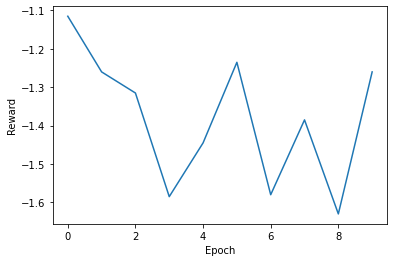

In [26]:
env = MarelleGymEnv(end_after_place_phase=False)

# Models
einstein_fc_model = FCModel(env.N_STATE, env.N_TOTAL_ACTIONS)
einstein_conv_model = ConvModel(env.N_TOTAL_ACTIONS)

# Agents
einstein_fc = SingleModelReinforce(env=env, player_id=1, model=einstein_fc_model, lr=0.005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)

einstein_conv = SingleModelReinforce(env=env, player_id=1, model=einstein_conv_model, lr=0.00005, win_reward=1, defeat_reward=-1, capture_reward=0.1, captured_reward=-0.1, epsilon=0, gamma=1)

# Opponents
opponent_agent=BetterRandomAgent(env, -1)
evaluate_agent=BetterRandomAgent(env,-1)

cProfile.run("""train_agent(
    env=env,
    n_epochs=10,
    n_trajectories=20,
    trained_agent=einstein_conv,
    opponent_agent=opponent_agent,
    evaluate_agent=evaluate_agent,
    log_training=False,
    save_model_freq=5,
    evaluate_freq=2
)""", sort='tottime')

In [35]:
evaluation_agent = einstein_conv
env.reset()
gabrielle = BetterRandomAgent(env, -1)
piccolo = BetterRandomAgent(env, 1)

cProfile.run("evaluate(env, einstein_conv, gabrielle, 100, 1)", sort="tottime")

         12232816 function calls (12224140 primitive calls) in 7.245 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    17261    1.734    0.000    4.569    0.000 marl_env.py:295(move_token_legal_actions)
  3075028    1.500    0.000    1.996    0.000 graph.py:656(nodes)
  3386710    0.559    0.000    0.559    0.000 reportviews.py:186(__getitem__)
  3075028    0.497    0.000    0.497    0.000 reportviews.py:176(__init__)
     6507    0.389    0.000    0.389    0.000 {built-in method conv2d}
   572913    0.384    0.000    0.387    0.000 reportviews.py:1116(__iter__)
   176551    0.363    0.000    0.455    0.000 marl_env.py:325(check_if_capture)
     3152    0.216    0.000    0.600    0.000 marl_env.py:252(place_token_legal_actions)
     2169    0.166    0.000    0.283    0.000 marl_models.py:41(transform_input_to_mat)
     8858    0.165    0.000    0.369    0.000 marl_env.py:227(get_state)
     4338    0.093    0.000    0.093